# Comparación entre Calidad de Características y Escala Estándar de Datos

Se va a comparar el comportamiento de 4 diferentes clasificadores, **Regresión Logística**, **Support Vector Machine** con kernel gaussiano, **Random Forest** y un **Multilayer Perceptron** (red neuronal). 
, variando la calidad de extracción de características de la librería **MAAD**, entre low **med**, medium **med** y high **high**.

In [149]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import pandas as pd
from time import process_time
from matplotlib.colors import Normalize
#plt.style.use('ggplot')
#plt.style.use(['ggplot','seaborn-paper'])
import seaborn as sns
import joblib
from maad.rois import find_rois_cwt
from maad import sound
import settings
from soundclim_utilities import (features_to_csv, 
                                 batch_find_rois, 
                                 batch_feature_rois, 
                                 listdir_pattern)

In [150]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

In [151]:
def log_reg(param_grid, X_train, y_train, X_test, y_test):
    clf_log_reg = GridSearchCV(LogisticRegression(solver= 'liblinear'), param_grid=param_grid_log_reg, verbose=0, 
                           return_train_score=True, n_jobs=-1, cv=5) 
    clf_log_reg.fit(X_train, y_train)
    cv_results = pd.DataFrame(clf_log_reg.cv_results_)
    scores = clf_log_reg.cv_results_['mean_test_score'].reshape(len(param_grid_log_reg['C']))
    print('Best Params:',clf_log_reg.best_params_, '\n')
    y_pred_log_reg = clf_log_reg.predict(X_test)
    print(classification_report(y_test,y_pred_log_reg))
    return clf_log_reg.best_params_, classification_report(y_test,y_pred_log_reg)

In [152]:
def SVM_rbf_clf(param_grid, X_train, y_train, X_test, y_test):
    clf_svm_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, verbose=0, 
                               return_train_score=True, cv=5)
    clf_svm_rbf.fit(X_train, y_train)
    cv_results_svm_rbf = pd.DataFrame(clf_svm_rbf.cv_results_)
    scores_svm_rbf = clf_svm_rbf.cv_results_['mean_test_score'].reshape(len(param_grid_svm_rbf['C']),
                                                                        len(param_grid_svm_rbf['gamma'])) 
    heat_map_2d('gamma', 'C', param_grid_svm_rbf, scores_svm_rbf)
    print('Best Params:',clf_svm_rbf.best_params_, '\n')
    y_pred_svm_rbf = clf_svm_rbf.predict(X_test)
    print(classification_report(y_test,y_pred_svm_rbf))
    return clf_svm_rbf.best_params_, classification_report(y_test,y_pred_svm_rbf)

In [153]:
def random_forests_clf(param_grid, X_train, y_train, X_test, y_test):
    clf_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rf, verbose=0, 
                          return_train_score=True, n_jobs=-1, cv=5)
    clf_rf.fit(X_train, y_train)
    cv_results_rf = pd.DataFrame(clf_rf.cv_results_)
    scores_rf = clf_rf.cv_results_['mean_test_score'].reshape(len(param_grid_rf['n_estimators']),
                                                              len(param_grid_rf['max_features'])) 
    heat_map_2d('n_estimators', 'max_features', param_grid_rf, scores_rf)
    print('Best Params:', clf_rf.best_params_, '\n')
    y_pred_rf = clf_rf.predict(X_test)
    print(classification_report(y_test,y_pred_rf))
    return clf_rf.best_params_, classification_report(y_test,y_pred_rf)

In [154]:
def mlp_clf(param_grid, X_train, y_train, X_test, y_test):
    clf_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1200), param_grid=param_grid_mlp, verbose=0, 
                       return_train_score=True, n_jobs=-1, cv=5)
    clf_mlp.fit(X_train, y_train)
    cv_results_mlp = pd.DataFrame(clf_mlp.cv_results_)
    scores_mlp = clf_mlp.cv_results_['mean_test_score'].reshape(len(param_grid_mlp['alpha']),
                                                          len(param_grid_mlp['hidden_layer_sizes'])) 
    heat_map_2d('alpha', 'hidden_layer_sizes', param_grid_mlp, scores_mlp)
    print('Best Params:', clf_mlp.best_params_, '\n') 
    y_pred_mlp = clf_mlp.predict(X_test)
    print(classification_report(y_test,y_pred_mlp))
    return clf_mlp.best_params_, classification_report(y_test,y_pred_mlp)

In [155]:
# Función para visualizar un conjunto de datos en 2D
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [156]:
def heat_map_2d(name_param_1, name_param_2, param_grid, scores):
    
    
    plt.figure(figsize=(10, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.5, midpoint=0.75, vmax=1.0))
    plt.xlabel(name_param_1)
    plt.ylabel(name_param_2)
    plt.colorbar()
    plt.xticks(np.arange(len(param_grid[name_param_1])), param_grid[name_param_1], rotation=45)
    plt.yticks(np.arange(len(param_grid[name_param_2])), param_grid[name_param_2])
    plt.title('Accuracy en validación')
    plt.show()

In [157]:
def feature_extraction(quality, id_rois):
    settings_man = settings.features
    settings_man['opt_shape_str'] = quality
    flist = listdir_pattern(settings.path_audio['train'], ends_with='.wav')
    flist = pd.DataFrame(flist, columns=['fname'])
    t_start = process_time()
    detection_data = batch_find_rois(flist, settings.detection, 
                                 settings.path_audio['train']) 
    rois_list = detection_data['detections']
    features = batch_feature_rois(rois_list, settings_man, settings.path_audio['train'])  
    t_stop = process_time() 
    df_features = features_to_csv(features).loc[id_rois, :]
    df_features.reset_index(inplace=True, drop=True)
    return df_features, t_stop-t_start

In [158]:
def class_matching(df_features):
    df = pd.concat([df_features,
                    lab_wname,
                    lab_bin],
                    axis=1)
    df.reset_index(inplace=True, drop=True)
    df.dropna(axis=0, inplace=True)
    df = df.loc[~df.lab_wname.isin(['1_vfar','1_ago']),:]
    df['lab_gt'] = df['lab_gt'].astype(int)
    return df

In [159]:
path_id_rois = './trainds/id_rois.csv'
path_mannot = './trainds/trainds_mannot.txt'
path_low  = './df_features/df_features_low.csv'
path_med  = './df_features/df_features_med.csv'
path_high = './df_features/df_features_high.csv'
path_times = './df_features/df_times.csv'

# Extracción de Características

A continuación se muestra el proceso para la extracción de las 3 calidades de características. 

In [94]:
df_id_rois = pd.read_csv(path_id_rois)
id_rois = df_id_rois['id_rois'].to_list()

In [95]:
df_features_low, t_low = feature_extraction('low', id_rois)

1 / 312 BETA_20161121_114000.wav
2 / 312 BETA_20161112_180000.wav
3 / 312 BETA_20170428_060000.wav
4 / 312 BETA_20170508_194000.wav
5 / 312 BETA_20170310_010000.wav
6 / 312 BETA_20170210_172000.wav
7 / 312 BETA-_20161023_032000.wav
8 / 312 BETA-_20161014_152000.wav
9 / 312 BETA_20170123_234000.wav
10 / 312 BETA-_20161001_200000.wav
11 / 312 BETA_20161121_054000.wav
12 / 312 BETA_20170421_000000.wav
13 / 312 BETA_20170524_084000.wav
14 / 312 BETA_20161228_014000.wav
15 / 312 BETA_20170126_174000.wav
16 / 312 BETA_20170118_180000.wav
17 / 312 BETA_20161128_170000.wav
18 / 312 BETA_20170313_160000.wav
19 / 312 BETA_20170403_060000.wav
20 / 312 BETA_20170414_182000.wav
21 / 312 BETA_20170116_030000.wav
22 / 312 BETA-_20161019_094000.wav
23 / 312 BETA-_20161003_214000.wav
24 / 312 BETA_20170415_052000.wav
25 / 312 BETA-_20161109_070000.wav
26 / 312 BETA_20170315_140000.wav
27 / 312 BETA_20161121_230000.wav
28 / 312 BETA_20161117_120000.wav
29 / 312 BETA_20170402_180000.wav
30 / 312 BETA_201

211 / 312 BETA_20170117_034000.wav
212 / 312 BETA_20170405_232000.wav
213 / 312 BETA_20170128_134000.wav
214 / 312 BETA_20170302_140000.wav
215 / 312 BETA_20170508_024000.wav
216 / 312 BETA_20170113_230000.wav
217 / 312 BETA_20170304_110000.wav
218 / 312 BETA_20170303_104000.wav
219 / 312 BETA_20170220_190000.wav
220 / 312 BETA_20170303_232000.wav
221 / 312 BETA_20170403_084000.wav
222 / 312 BETA_20170202_224000.wav
223 / 312 BETA_20170317_080000.wav
224 / 312 BETA_20170303_192000.wav
225 / 312 BETA-_20161016_064000.wav
226 / 312 BETA_20170306_120000.wav
227 / 312 BETA_20161122_210000.wav
228 / 312 BETA_20161205_210000.wav
229 / 312 BETA_20161124_204000.wav
230 / 312 BETA_20170506_064000.wav
231 / 312 BETA_20170403_142000.wav
232 / 312 BETA_20161120_010000.wav
233 / 312 BETA_20161207_212000.wav
234 / 312 BETA-_20161004_102000.wav
235 / 312 BETA_20161224_120000.wav
236 / 312 BETA-_20161030_074000.wav
237 / 312 BETA_20170412_174000.wav
238 / 312 BETA_20161218_002000.wav
239 / 312 BETA_20

107 / 312 BETA_20161120_140000.wav
108 / 312 BETA_20161210_040000.wav
109 / 312 BETA-_20161015_090000.wav
110 / 312 BETA_20170310_014000.wav
< No detection on file >
111 / 312 BETA_20161116_092000.wav
112 / 312 BETA-_20161008_132000.wav
113 / 312 BETA_20170517_014000.wav
114 / 312 BETA-_20161103_122000.wav
115 / 312 BETA_20170321_040000.wav
< No detection on file >
116 / 312 BETA-_20161101_062000.wav
117 / 312 BETA_20170413_032000.wav
118 / 312 BETA_20161110_182000.wav
119 / 312 BETA_20170128_232000.wav
120 / 312 BETA_20170320_024000.wav
121 / 312 BETA-_20161022_234000.wav
122 / 312 BETA_20170118_070000.wav
< No detection on file >
123 / 312 BETA_20161116_050000.wav
124 / 312 BETA_20161118_062000.wav
125 / 312 BETA_20170417_170000.wav
126 / 312 BETA_20170103_004000.wav
127 / 312 BETA_20170117_182000.wav
128 / 312 BETA_20170319_024000.wav
129 / 312 BETA_20161214_232000.wav
130 / 312 BETA-_20161016_140000.wav
131 / 312 BETA_20170302_010000.wav
132 / 312 BETA_20161207_054000.wav
133 / 312

In [96]:
df_features_med, t_med = feature_extraction('med', id_rois)

1 / 312 BETA_20161121_114000.wav
2 / 312 BETA_20161112_180000.wav
3 / 312 BETA_20170428_060000.wav
4 / 312 BETA_20170508_194000.wav
5 / 312 BETA_20170310_010000.wav
6 / 312 BETA_20170210_172000.wav
7 / 312 BETA-_20161023_032000.wav
8 / 312 BETA-_20161014_152000.wav
9 / 312 BETA_20170123_234000.wav
10 / 312 BETA-_20161001_200000.wav
11 / 312 BETA_20161121_054000.wav
12 / 312 BETA_20170421_000000.wav
13 / 312 BETA_20170524_084000.wav
14 / 312 BETA_20161228_014000.wav
15 / 312 BETA_20170126_174000.wav
16 / 312 BETA_20170118_180000.wav
17 / 312 BETA_20161128_170000.wav
18 / 312 BETA_20170313_160000.wav
19 / 312 BETA_20170403_060000.wav
20 / 312 BETA_20170414_182000.wav
21 / 312 BETA_20170116_030000.wav
22 / 312 BETA-_20161019_094000.wav
23 / 312 BETA-_20161003_214000.wav
24 / 312 BETA_20170415_052000.wav
25 / 312 BETA-_20161109_070000.wav
26 / 312 BETA_20170315_140000.wav
27 / 312 BETA_20161121_230000.wav
28 / 312 BETA_20161117_120000.wav
29 / 312 BETA_20170402_180000.wav
30 / 312 BETA_201

211 / 312 BETA_20170117_034000.wav
212 / 312 BETA_20170405_232000.wav
213 / 312 BETA_20170128_134000.wav
214 / 312 BETA_20170302_140000.wav
215 / 312 BETA_20170508_024000.wav
216 / 312 BETA_20170113_230000.wav
217 / 312 BETA_20170304_110000.wav
218 / 312 BETA_20170303_104000.wav
219 / 312 BETA_20170220_190000.wav
220 / 312 BETA_20170303_232000.wav
221 / 312 BETA_20170403_084000.wav
222 / 312 BETA_20170202_224000.wav
223 / 312 BETA_20170317_080000.wav
224 / 312 BETA_20170303_192000.wav
225 / 312 BETA-_20161016_064000.wav
226 / 312 BETA_20170306_120000.wav
227 / 312 BETA_20161122_210000.wav
228 / 312 BETA_20161205_210000.wav
229 / 312 BETA_20161124_204000.wav
230 / 312 BETA_20170506_064000.wav
231 / 312 BETA_20170403_142000.wav
232 / 312 BETA_20161120_010000.wav
233 / 312 BETA_20161207_212000.wav
234 / 312 BETA-_20161004_102000.wav
235 / 312 BETA_20161224_120000.wav
236 / 312 BETA-_20161030_074000.wav
237 / 312 BETA_20170412_174000.wav
238 / 312 BETA_20161218_002000.wav
239 / 312 BETA_20

107 / 312 BETA_20161120_140000.wav
108 / 312 BETA_20161210_040000.wav
109 / 312 BETA-_20161015_090000.wav
110 / 312 BETA_20170310_014000.wav
< No detection on file >
111 / 312 BETA_20161116_092000.wav
112 / 312 BETA-_20161008_132000.wav
113 / 312 BETA_20170517_014000.wav
114 / 312 BETA-_20161103_122000.wav
115 / 312 BETA_20170321_040000.wav
< No detection on file >
116 / 312 BETA-_20161101_062000.wav
117 / 312 BETA_20170413_032000.wav
118 / 312 BETA_20161110_182000.wav
119 / 312 BETA_20170128_232000.wav
120 / 312 BETA_20170320_024000.wav
121 / 312 BETA-_20161022_234000.wav
122 / 312 BETA_20170118_070000.wav
< No detection on file >
123 / 312 BETA_20161116_050000.wav
124 / 312 BETA_20161118_062000.wav
125 / 312 BETA_20170417_170000.wav
126 / 312 BETA_20170103_004000.wav
127 / 312 BETA_20170117_182000.wav
128 / 312 BETA_20170319_024000.wav
129 / 312 BETA_20161214_232000.wav
130 / 312 BETA-_20161016_140000.wav
131 / 312 BETA_20170302_010000.wav
132 / 312 BETA_20161207_054000.wav
133 / 312

In [97]:
df_features_high, t_high = feature_extraction('high', id_rois)

1 / 312 BETA_20161121_114000.wav
2 / 312 BETA_20161112_180000.wav
3 / 312 BETA_20170428_060000.wav
4 / 312 BETA_20170508_194000.wav
5 / 312 BETA_20170310_010000.wav
6 / 312 BETA_20170210_172000.wav
7 / 312 BETA-_20161023_032000.wav
8 / 312 BETA-_20161014_152000.wav
9 / 312 BETA_20170123_234000.wav
10 / 312 BETA-_20161001_200000.wav
11 / 312 BETA_20161121_054000.wav
12 / 312 BETA_20170421_000000.wav
13 / 312 BETA_20170524_084000.wav
14 / 312 BETA_20161228_014000.wav
15 / 312 BETA_20170126_174000.wav
16 / 312 BETA_20170118_180000.wav
17 / 312 BETA_20161128_170000.wav
18 / 312 BETA_20170313_160000.wav
19 / 312 BETA_20170403_060000.wav
20 / 312 BETA_20170414_182000.wav
21 / 312 BETA_20170116_030000.wav
22 / 312 BETA-_20161019_094000.wav
23 / 312 BETA-_20161003_214000.wav
24 / 312 BETA_20170415_052000.wav
25 / 312 BETA-_20161109_070000.wav
26 / 312 BETA_20170315_140000.wav
27 / 312 BETA_20161121_230000.wav
28 / 312 BETA_20161117_120000.wav
29 / 312 BETA_20170402_180000.wav
30 / 312 BETA_201

210 / 312 BETA_20170424_134000.wav
211 / 312 BETA_20170117_034000.wav
212 / 312 BETA_20170405_232000.wav
213 / 312 BETA_20170128_134000.wav
214 / 312 BETA_20170302_140000.wav
215 / 312 BETA_20170508_024000.wav
216 / 312 BETA_20170113_230000.wav
217 / 312 BETA_20170304_110000.wav
218 / 312 BETA_20170303_104000.wav
219 / 312 BETA_20170220_190000.wav
220 / 312 BETA_20170303_232000.wav
221 / 312 BETA_20170403_084000.wav
222 / 312 BETA_20170202_224000.wav
223 / 312 BETA_20170317_080000.wav
224 / 312 BETA_20170303_192000.wav
225 / 312 BETA-_20161016_064000.wav
226 / 312 BETA_20170306_120000.wav
227 / 312 BETA_20161122_210000.wav
228 / 312 BETA_20161205_210000.wav
229 / 312 BETA_20161124_204000.wav
230 / 312 BETA_20170506_064000.wav
231 / 312 BETA_20170403_142000.wav
232 / 312 BETA_20161120_010000.wav
233 / 312 BETA_20161207_212000.wav
234 / 312 BETA-_20161004_102000.wav
235 / 312 BETA_20161224_120000.wav
236 / 312 BETA-_20161030_074000.wav
237 / 312 BETA_20170412_174000.wav
238 / 312 BETA_20

107 / 312 BETA_20161120_140000.wav
108 / 312 BETA_20161210_040000.wav
109 / 312 BETA-_20161015_090000.wav
110 / 312 BETA_20170310_014000.wav
< No detection on file >
111 / 312 BETA_20161116_092000.wav
112 / 312 BETA-_20161008_132000.wav
113 / 312 BETA_20170517_014000.wav
114 / 312 BETA-_20161103_122000.wav
115 / 312 BETA_20170321_040000.wav
< No detection on file >
116 / 312 BETA-_20161101_062000.wav
117 / 312 BETA_20170413_032000.wav
118 / 312 BETA_20161110_182000.wav
119 / 312 BETA_20170128_232000.wav
120 / 312 BETA_20170320_024000.wav
121 / 312 BETA-_20161022_234000.wav
122 / 312 BETA_20170118_070000.wav
< No detection on file >
123 / 312 BETA_20161116_050000.wav
124 / 312 BETA_20161118_062000.wav
125 / 312 BETA_20170417_170000.wav
126 / 312 BETA_20170103_004000.wav
127 / 312 BETA_20170117_182000.wav
128 / 312 BETA_20170319_024000.wav
129 / 312 BETA_20161214_232000.wav
130 / 312 BETA-_20161016_140000.wav
131 / 312 BETA_20170302_010000.wav
132 / 312 BETA_20161207_054000.wav
133 / 312

In [160]:
times = {'Time Low (s)': [t_low], 'Time Med (s)' : [t_med],'Time High (s)': [t_high]}
df_times = pd.DataFrame(times)

In [8]:
df_features_low.to_csv(path_low, index=False)
df_features_med.to_csv(path_med, index=False)
df_features_high.to_csv(path_high, index=False)
df_times.to_csv(path_times, index=False)

# Procesamiento de Datos

Ahora se hace el proceso de preparación de los datos para entrenar los modelos:

In [12]:
df_features_low  = pd.read_csv(path_low)
df_features_med  = pd.read_csv(path_med)
df_features_high = pd.read_csv(path_high)
df_times = pd.read_csv(path_times)

In [13]:
df_features_med.head()

,min_f,min_t,max_f,max_t,shp_001,shp_002,shp_003,shp_004,shp_005,shp_006,...,shp_041,shp_042,shp_043,shp_044,shp_045,shp_046,shp_047,shp_048,frequency,fname
0,1033.59375,13.641723,3962.109375,13.943583,0.215264,0.190990,0.181079,0.124634,0.116268,0.126183,...,0.288658,0.432378,0.096456,0.133245,0.081844,0.245924,0.134406,0.140101,2540.917969,BETA-_20161029_070000.wav
1,1033.59375,89.327166,3962.109375,89.629025,0.182053,0.154664,0.157382,0.121428,0.114540,0.134009,...,0.262315,0.525691,0.239708,0.344254,0.154582,0.156503,0.243071,0.351401,2540.917969,BETA_20161115_160000.wav
2,1033.59375,40.449161,3962.109375,40.704580,0.233314,0.220245,0.186017,0.152007,0.126293,0.154195,...,0.418175,0.353023,0.119964,0.194960,0.096618,0.138694,0.248574,0.250988,2454.785156,BETA_20161128_032000.wav
3,1033.59375,81.885170,3962.109375,82.198639,0.169950,0.158950,0.167527,0.131663,0.107573,0.136715,...,0.194589,0.295191,0.090208,0.060823,0.040825,0.083359,0.078811,0.067376,2540.917969,BETA-_20161109_070000.wav
4,1033.59375,10.100680,3962.109375,10.425760,0.210391,0.201080,0.181107,0.144180,0.115546,0.134888,...,0.252186,0.202034,0.066697,0.036928,0.082994,0.135330,0.089679,0.080279,2497.851562,BETA_20161112_100000.wav


In [14]:
gt = pd.read_csv(path_mannot, header=None, usecols=[0,1,2], sep='\t', 
                 names=['onset','offset','label'])
idx_annotated = (gt.label.str[1]=='_')
lab_wname = gt['label']
lab_wname.loc[~idx_annotated] = np.nan
lab_bin = lab_wname.str[0]
lab_bin.name = 'lab_gt'
lab_wname.name = 'lab_wname'

/home/juanfe/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
df_features_low = class_matching(df_features_low)
df_features_med = class_matching(df_features_med)
df_features_high = class_matching(df_features_high)

In [16]:
X_low = df_features_low.loc[:,df_features_low.columns.str.startswith('shp')].values
y_low = df_features_low.loc[:,'lab_gt'].values

In [17]:
X_med = df_features_med.loc[:,df_features_med.columns.str.startswith('shp')].values
y_med = df_features_med.loc[:,'lab_gt'].values

In [18]:
X_high = df_features_high.loc[:,df_features_high.columns.str.startswith('shp')].values
y_high = df_features_high.loc[:,'lab_gt'].values

# Modelos

A continuación se entrenan los modelos mediante **GridSearch** con un **cv** de **5**, y se presentan los mejores parámetros para cada modelo y para cada calidad de características. 

In [19]:
from sklearn.model_selection import train_test_split

def split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3,
                                                        random_state=42,
                                                        stratify=y,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

In [20]:
X_train_low, X_test_low, y_train_low, y_test_low = split(X_low, y_low)

In [21]:
X_train_med, X_test_med, y_train_med, y_test_med = split(X_med, y_med)

In [22]:
X_train_high, X_test_high, y_train_high, y_test_high = split(X_high, y_high)

In [58]:
n = 10

# Regrasion Logistica

In [24]:
grid_log_reg = [i for i in range(1, 11, 1)]
param_grid_log_reg = {'C': [np.round((0.1*i), decimals =2) for i in grid_log_reg]}
print('Parameters:', param_grid_log_reg)

Parameters: {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


## low quality

In [25]:
best_params_log_reg_low, report_log_reg_low = log_reg(param_grid_log_reg, X_train_low, y_train_low, 
                                                      X_test_low, y_test_low)

Best Params: {'C': 1.0} 

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       221
           1       0.97      0.80      0.88       112

   micro avg       0.92      0.92      0.92       333
   macro avg       0.94      0.89      0.91       333
weighted avg       0.93      0.92      0.92       333



In [26]:
clf_log_reg_low = LogisticRegression(solver= 'liblinear', C=best_params_log_reg_low['C'])

t_start = process_time()
for i in range(n):
    y_scores_log_reg_low = cross_val_predict(clf_log_reg_low, X_train_low, y_train_low, cv=5, 
                                             method='decision_function', n_jobs=-1)
t_stop = process_time()
t_log_reg_low = (t_stop-t_start)/n

In [27]:
precisions_log_reg_low, recalls_log_reg_low, thresholds_log_reg_low = precision_recall_curve(y_train_low, 
                                                                                             y_scores_log_reg_low)

In [28]:
fpr_log_reg_low, tpr_log_reg_low, thresholds_roc_log_reg_low = roc_curve(y_train_low, y_scores_log_reg_low)

In [119]:
PR_AUC_log_reg_low = metrics.auc(recalls_log_reg_low, precisions_log_reg_low)

# med quality

In [29]:
best_params_log_reg_med, report_log_reg_med = log_reg(param_grid_log_reg, X_train_med, y_train_med, 
                                                      X_test_med, y_test_med)

Best Params: {'C': 1.0} 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       221
           1       0.96      0.92      0.94       112

   micro avg       0.96      0.96      0.96       333
   macro avg       0.96      0.95      0.96       333
weighted avg       0.96      0.96      0.96       333



In [30]:
clf_log_reg_med = LogisticRegression(solver= 'liblinear', C=best_params_log_reg_med['C'])

t_start = process_time()
for i in range(n):
    y_scores_log_reg_med = cross_val_predict(clf_log_reg_med, X_train_med, y_train_med, cv=5, 
                                         method='decision_function', n_jobs=-1)
t_stop = process_time()
t_log_reg_med = (t_stop-t_start)/n

In [31]:
precisions_log_reg_med, recalls_log_reg_med, thresholds_log_reg_med = precision_recall_curve(y_train_med, 
                                                                                             y_scores_log_reg_med)

In [32]:
fpr_log_reg_med, tpr_log_reg_med, thresholds_roc_log_reg_med = roc_curve(y_train_med, y_scores_log_reg_med)

In [120]:
PR_AUC_log_reg_med = metrics.auc(recalls_log_reg_med, precisions_log_reg_med)

## high quality

In [33]:
best_params_log_reg_high, report_log_reg_high = log_reg(param_grid_log_reg, X_train_high, y_train_high, 
                                                        X_test_high, y_test_high)

Best Params: {'C': 1.0} 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       221
           1       0.97      0.93      0.95       112

   micro avg       0.97      0.97      0.97       333
   macro avg       0.97      0.96      0.96       333
weighted avg       0.97      0.97      0.97       333



In [34]:
clf_log_reg_high = LogisticRegression(solver= 'liblinear', C=best_params_log_reg_high['C'])

t_start = process_time()
for i in range(n):
    y_scores_log_reg_high = cross_val_predict(clf_log_reg_high, X_train_high, y_train_med, cv=5, 
                                          method='decision_function', n_jobs=-1)
t_stop = process_time()
t_log_reg_high = (t_stop-t_start)/n

In [35]:
precisions_log_reg_high, recalls_log_reg_high, thresholds_log_reg_high = precision_recall_curve(y_train_high, 
                                                                         y_scores_log_reg_high)

In [36]:
fpr_log_reg_high, tpr_log_reg_high, thresholds_roc_log_reg_high = roc_curve(y_train_high, y_scores_log_reg_high)

In [121]:
PR_AUC_log_reg_high = metrics.auc(recalls_log_reg_high, precisions_log_reg_high)

In [37]:
roc_auc_log_reg_low = roc_auc_score(y_train_low, y_scores_log_reg_low)
roc_auc_log_reg_med = roc_auc_score(y_train_med, y_scores_log_reg_med)
roc_auc_log_reg_high = roc_auc_score(y_train_high, y_scores_log_reg_high)

# Support Vector Machine - rbf (Kernel Gausiano)

In [38]:
grid_C = [i for i in range(-5, 7, 1)]
grid_gamma = [i for i in range(0, 11, 1)]
param_grid_svm_rbf = {'C': [2**i for i in grid_C], 
                      'gamma': np.round([0.1*i for i in grid_gamma], decimals=2)}
print('Parameters:', param_grid_svm_rbf)

Parameters: {'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64], 'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])}


## low quality

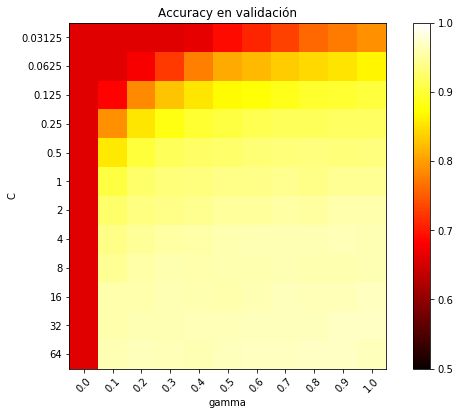

Best Params: {'C': 32, 'gamma': 0.9} 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       221
           1       0.98      0.95      0.96       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.98      0.97      0.97       333
weighted avg       0.98      0.98      0.98       333



In [39]:
best_params_SVC_low, report_SVC_low = SVM_rbf_clf(param_grid_svm_rbf, X_train_low, y_train_low, 
                                                  X_test_low, y_test_low)

In [40]:
clf_SVC_low = SVC(kernel='rbf', C=best_params_SVC_low['C'], gamma=best_params_SVC_low['gamma'])

t_start = process_time()
for i in range(n):
    y_scores_SVC_low = cross_val_predict(clf_SVC_low, X_train_low, y_train_low, cv=5, 
                                         method='decision_function', n_jobs=-1)
t_stop = process_time()
t_SVC_low = (t_stop-t_start)/n

In [41]:
precisions_SVC_low, recalls_SVC_low, thresholds_SVC_low = precision_recall_curve(y_train_low, 
                                                                                 y_scores_SVC_low)

In [42]:
fpr_SVC_low, tpr_SVC_low, thresholds_roc_SVC_low = roc_curve(y_train_low, y_scores_SVC_low)

In [122]:
PR_AUC_SVC_low = metrics.auc(recalls_SVC_low, precisions_SVC_low)

## medium quality

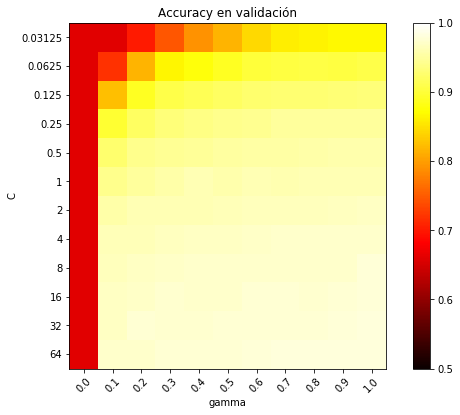

Best Params: {'C': 64, 'gamma': 1.0} 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       221
           1       0.98      0.95      0.96       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.98      0.97      0.97       333
weighted avg       0.98      0.98      0.98       333



In [43]:
best_params_SVC_med, report_SVC_med = SVM_rbf_clf(param_grid_svm_rbf, X_train_med, y_train_med, 
                                                  X_test_med, y_test_med)

In [44]:
clf_SVC_med = SVC(kernel='rbf', C=best_params_SVC_med['C'], gamma=best_params_SVC_med['gamma'])

t_start = process_time()
for i in range(n):
    y_scores_SVC_med = cross_val_predict(clf_SVC_med, X_train_med, y_train_med, cv=5, 
                                     method='decision_function', n_jobs=-1)
t_stop = process_time()
t_SVC_med = (t_stop-t_start)/n

In [45]:
precisions_SVC_med, recalls_SVC_med, thresholds_SVC_med = precision_recall_curve(y_train_med, 
                                                                                 y_scores_SVC_med)

In [46]:
fpr_SVC_med, tpr_SVC_med, thresholds_roc_SVC_med = roc_curve(y_train_med, y_scores_SVC_med)

In [123]:
PR_AUC_SVC_med = metrics.auc(recalls_SVC_med, precisions_SVC_med)

## high quality

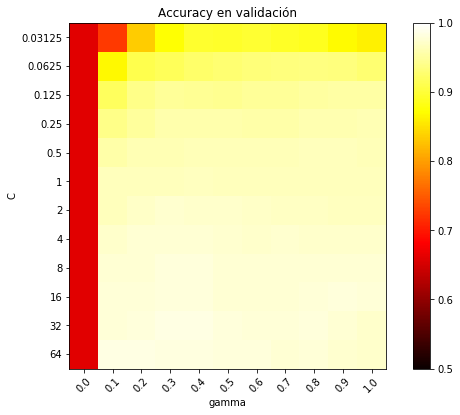

Best Params: {'C': 32, 'gamma': 0.3} 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       221
           1       0.99      0.96      0.97       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333



In [47]:
best_params_SVC_high, report_SVC_high = SVM_rbf_clf(param_grid_svm_rbf, X_train_high, y_train_high, 
                                                    X_test_high, y_test_high)

In [48]:
clf_SVC_high = SVC(kernel='rbf', C=best_params_SVC_high['C'], gamma=best_params_SVC_high['gamma'])

t_start = process_time()
for i in range(n):
    y_scores_SVC_high = cross_val_predict(clf_SVC_high, X_train_high, y_train_high, cv=5, 
                                         method='decision_function', n_jobs=-1)
t_stop = process_time()
t_SVC_high = t_stop-t_start

In [49]:
precisions_SVC_high, recalls_SVC_high, thresholds_SVC_high = precision_recall_curve(y_train_high, 
                                                                                    y_scores_SVC_high)

In [50]:
fpr_SVC_high, tpr_SVC_high, thresholds_roc_SVC_high = roc_curve(y_train_high, y_scores_SVC_high)

In [124]:
PR_AUC_SVC_high = metrics.auc(recalls_SVC_high, precisions_SVC_high)

In [51]:
roc_auc_SVC_low = roc_auc_score(y_train_low, y_scores_SVC_low)
roc_auc_SVC_med = roc_auc_score(y_train_med, y_scores_SVC_med)
roc_auc_SVC_high = roc_auc_score(y_train_high, y_scores_SVC_high)

# Random Forests

In [52]:
max_features_params_rf = [np.round(10**-1 * i, decimals=2) for i in range(1, 11, 1)]
param_grid_rf = {'n_estimators': [2**i for i in range(2, 12, 1)], 'max_features': max_features_params_rf}
print('Parameters:', param_grid_rf)

Parameters: {'n_estimators': [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


## low quality

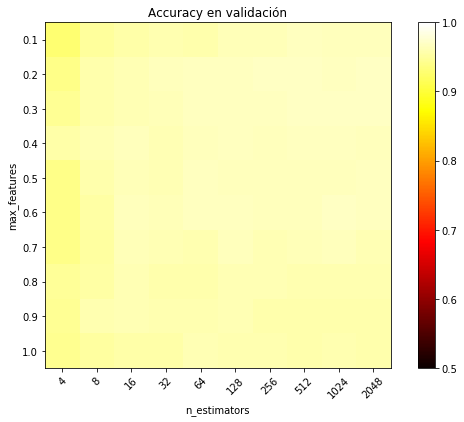

Best Params: {'max_features': 0.2, 'n_estimators': 256} 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       221
           1       0.99      0.95      0.97       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.98      0.97      0.98       333
weighted avg       0.98      0.98      0.98       333



In [53]:
best_params_rf_low, report_rf_low = random_forests_clf(param_grid_rf, X_train_low, y_train_low, 
                                                       X_test_low, y_test_low)

In [54]:
clf_rf_low = RandomForestClassifier(random_state=42, n_estimators=best_params_rf_low['n_estimators'], 
                                     max_features=best_params_rf_low['max_features'])

t_start = process_time()
for i in range(n):
    y_scores_rf_low = cross_val_predict(clf_rf_low, X_train_low, y_train_low, cv=5, 
                                     method='predict_proba', n_jobs=-1)
t_stop = process_time()
t_rf_low = (t_stop-t_start)/n

In [55]:
precisions_rf_low, recalls_rf_low, thresholds_rf_low = precision_recall_curve(y_train_low, 
                                                                                 y_scores_rf_low[:,1])

In [56]:
fpr_rf_low, tpr_rf_low, thresholds_roc_rf_low = roc_curve(y_train_low, y_scores_rf_low[:,1])

In [125]:
PR_AUC_rf_low = metrics.auc(recalls_rf_low, precisions_rf_low)

## medium quality

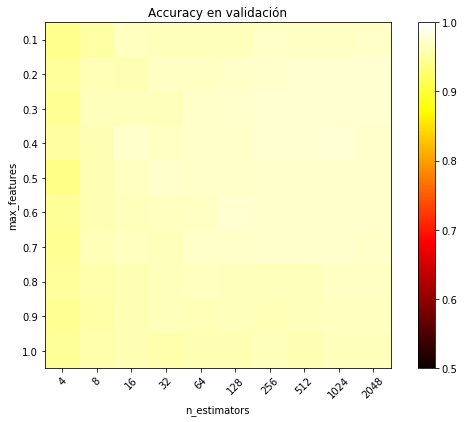

Best Params: {'max_features': 0.4, 'n_estimators': 1024} 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       221
           1       1.00      0.96      0.98       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.99      0.98      0.98       333
weighted avg       0.99      0.98      0.98       333



In [59]:
best_params_rf_med, report_rf_med = random_forests_clf(param_grid_rf, X_train_med, y_train_med, 
                                                       X_test_med, y_test_med)

In [60]:
clf_rf_med = RandomForestClassifier(random_state=42, n_estimators=best_params_rf_med['n_estimators'], 
                                     max_features=best_params_rf_med['max_features'])

t_start = process_time()
for i in range(n):
    y_scores_rf_med = cross_val_predict(clf_rf_med, X_train_med, y_train_med, cv=5, 
                                         method='predict_proba', n_jobs=-1)
t_stop = process_time()
t_rf_med = (t_stop-t_start)/n

In [61]:
precisions_rf_med, recalls_rf_med, thresholds_rf_med = precision_recall_curve(y_train_med, 
                                                                              y_scores_rf_med[:,1])

In [62]:
fpr_rf_med, tpr_rf_med, thresholds_roc_rf_med = roc_curve(y_train_med, y_scores_rf_med[:,1])

In [126]:
PR_AUC_rf_med = metrics.auc(recalls_rf_med, precisions_rf_med)

## high quality

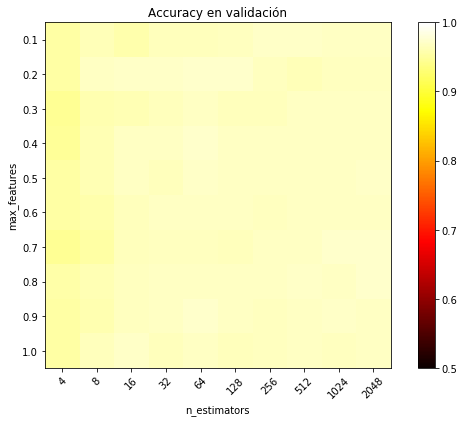

Best Params: {'max_features': 0.2, 'n_estimators': 64} 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       221
           1       1.00      0.96      0.98       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.99      0.98      0.98       333
weighted avg       0.99      0.98      0.98       333



In [63]:
best_params_rf_high, report_rf_high = random_forests_clf(param_grid_rf, X_train_high, y_train_high, 
                                                         X_test_high, y_test_high)

In [64]:
clf_rf_high = RandomForestClassifier(random_state=42, n_estimators=best_params_rf_high['n_estimators'], 
                                     max_features=best_params_rf_high['max_features'])

t_start = process_time()
for i in range(n):
    y_scores_rf_high = cross_val_predict(clf_rf_high, X_train_high, y_train_high, cv=5, 
                                         method='predict_proba', n_jobs=-1)
t_stop = process_time()
t_rf_high = (t_stop-t_start)/n

In [65]:
precisions_rf_high, recalls_rf_high, thresholds_rf_high = precision_recall_curve(y_train_high, 
                                                                              y_scores_rf_high[:,1])

In [66]:
fpr_rf_high, tpr_rf_high, thresholds_roc_rf_high = roc_curve(y_train_high, y_scores_rf_high[:,1])

In [127]:
PR_AUC_rf_high = metrics.auc(recalls_rf_high, precisions_rf_high)

In [67]:
roc_auc_rf_low = roc_auc_score(y_train_low, y_scores_rf_low[:,1])
roc_auc_rf_med = roc_auc_score(y_train_med, y_scores_rf_med[:,1])
roc_auc_rf_high = roc_auc_score(y_train_high, y_scores_rf_high[:,1])

# Red Neuronal

In [68]:
param_grid_mlp = {'alpha': [np.round(10**-1/4 * i, decimals=2) for i in range(1, 11, 1)], 
                  'hidden_layer_sizes': [2**i for i in range(2, 12, 1)]}
print('Parameters:', param_grid_mlp)

Parameters: {'alpha': [0.02, 0.05, 0.08, 0.1, 0.12, 0.15, 0.18, 0.2, 0.22, 0.25], 'hidden_layer_sizes': [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]}


## low quality

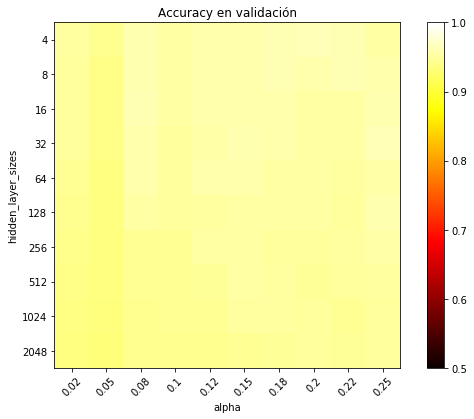

Best Params: {'alpha': 0.02, 'hidden_layer_sizes': 512} 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       221
           1       0.97      0.93      0.95       112

   micro avg       0.97      0.97      0.97       333
   macro avg       0.97      0.96      0.96       333
weighted avg       0.97      0.97      0.97       333



In [69]:
best_params_mlp_low, report_mlp_low = mlp_clf(param_grid_mlp, X_train_low, y_train_low, X_test_low, y_test_low)

In [70]:
clf_mlp_low = MLPClassifier(random_state=42, max_iter=1200, alpha=best_params_mlp_low['alpha'], 
                            hidden_layer_sizes=best_params_mlp_low['hidden_layer_sizes'])

t_start = process_time()
for i in range(n):
    y_scores_mlp_low = cross_val_predict(clf_mlp_low, X_train_low, y_train_low, cv=5, 
                                         method='predict_proba', n_jobs=-1)
t_stop = process_time()
t_mlp_low = (t_stop-t_start)/n

In [71]:
precisions_mlp_low, recalls_mlp_low, thresholds_mlp_low = precision_recall_curve(y_train_low, 
                                                                                 y_scores_mlp_low[:,1])

In [72]:
fpr_mlp_low, tpr_mlp_low, thresholds_roc_mlp_low = roc_curve(y_train_low, y_scores_mlp_low[:,1])

In [128]:
PR_AUC_mlp_low = metrics.auc(recalls_mlp_low, precisions_mlp_low)

## medium quality

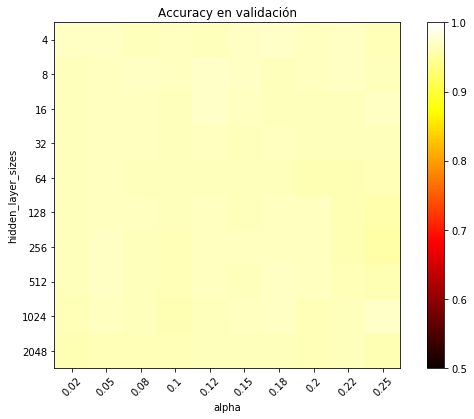

Best Params: {'alpha': 0.02, 'hidden_layer_sizes': 256} 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       221
           1       0.98      0.98      0.98       112

   micro avg       0.99      0.99      0.99       333
   macro avg       0.99      0.99      0.99       333
weighted avg       0.99      0.99      0.99       333



In [73]:
best_params_mlp_med, report_mlp_med = mlp_clf(param_grid_mlp, X_train_med, y_train_med, X_test_med, y_test_med)

In [74]:
n=10

In [75]:
clf_mlp_med = MLPClassifier(random_state=42, max_iter=1200, alpha=best_params_mlp_med['alpha'], 
                            hidden_layer_sizes=best_params_mlp_med['hidden_layer_sizes'])

t_start = process_time()
for i in range(n):
    y_scores_mlp_med = cross_val_predict(clf_mlp_med, X_train_med, y_train_med, cv=5, 
                                         method='predict_proba', n_jobs=-1)
t_stop = process_time()
t_mlp_med = (t_stop-t_start)/n

In [76]:
precisions_mlp_med, recalls_mlp_med, thresholds_mlp_med = precision_recall_curve(y_train_med, 
                                                                                 y_scores_mlp_med[:,1])

In [77]:
fpr_mlp_med, tpr_mlp_med, thresholds_roc_mlp_med = roc_curve(y_train_med, y_scores_mlp_med[:,1])

In [129]:
PR_AUC_mlp_med = metrics.auc(recalls_mlp_med, precisions_mlp_med)

## high quality

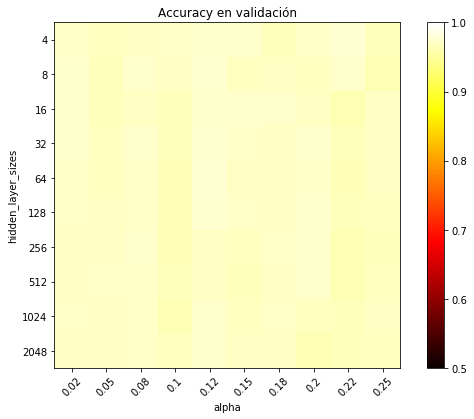

Best Params: {'alpha': 0.02, 'hidden_layer_sizes': 1024} 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       221
           1       0.97      0.96      0.97       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333



In [78]:
best_params_mlp_high, report_mlp_high = mlp_clf(param_grid_mlp, X_train_high, y_train_high, 
                                                X_test_high, y_test_high)

In [79]:
clf_mlp_high = MLPClassifier(random_state=42, max_iter=1200, alpha=best_params_mlp_high['alpha'], 
                             hidden_layer_sizes=best_params_mlp_high['hidden_layer_sizes'])

t_start = process_time()
for i in range(n):
    y_scores_mlp_high = cross_val_predict(clf_mlp_high, X_train_high, y_train_high, cv=5, 
                                          method='predict_proba', n_jobs=-1)
t_stop = process_time()
t_mlp_high = (t_stop-t_start)/n

In [80]:
precisions_mlp_high, recalls_mlp_high, thresholds_mlp_high = precision_recall_curve(y_train_high, 
                                                                                    y_scores_mlp_high[:,1])

In [81]:
fpr_mlp_high, tpr_mlp_high, thresholds_roc_mlp_high = roc_curve(y_train_high, y_scores_mlp_high[:,1])

In [130]:
PR_AUC_mlp_high = metrics.auc(recalls_mlp_high, precisions_mlp_high)

In [82]:
roc_auc_mlp_low = roc_auc_score(y_train_low, y_scores_mlp_low[:,1])
roc_auc_mlp_med = roc_auc_score(y_train_med, y_scores_mlp_med[:,1])
roc_auc_mlp_high = roc_auc_score(y_train_high, y_scores_mlp_high[:,1])

# Dada DF

In [254]:
df_times

,Time Low (s),Time Med (s),Time High (s)
0,556.436028,1032.896255,3245.325497


In [255]:
index_df = ['Best_Params', 'Report', 'Precisions', 'Recalls', 'Thresholds', 'False_Positives_Rate',
            'True_Positive_Rate', 'Thresholds_ROC', 'ROC_AUC', 'Processing_Time', 'PR_AUC']

In [256]:
df_low = pd.DataFrame(index=index_df)

df_low['LOG_REG'] = [best_params_log_reg_low, report_log_reg_low, 
                     precisions_log_reg_low, recalls_log_reg_low, thresholds_log_reg_low,
                     fpr_log_reg_low, tpr_log_reg_low, thresholds_roc_log_reg_low,
                     roc_auc_log_reg_low, t_log_reg_low, PR_AUC_log_reg_low]

df_low['SVC'] = [best_params_SVC_low, report_SVC_low,
                 precisions_SVC_low, recalls_SVC_low, thresholds_SVC_low,
                 fpr_SVC_low, tpr_SVC_low, thresholds_roc_SVC_low,
                 roc_auc_SVC_low, t_SVC_low, PR_AUC_SVC_low]

df_low['RF'] = [best_params_rf_low, report_rf_low,
                precisions_rf_low, recalls_rf_low, thresholds_rf_low,
                fpr_rf_low, tpr_rf_low, thresholds_roc_rf_low,
                roc_auc_rf_low, t_rf_low, PR_AUC_rf_low]

df_low['MLP'] = [best_params_mlp_low, report_mlp_low,
                 precisions_mlp_low, recalls_mlp_low, thresholds_mlp_low,
                 fpr_mlp_low, tpr_mlp_low, thresholds_roc_mlp_low,
                 roc_auc_mlp_low, t_mlp_low, PR_AUC_mlp_low]
df_low

,LOG_REG,SVC,RF,MLP
Best_Params,{'C': 1.0},"{'C': 32, 'gamma': 0.9}","{'max_features': 0.2, 'n_estimators': 256}","{'alpha': 0.02, 'hidden_layer_sizes': 512}"
Report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...
Precisions,"[0.4276422764227642, 0.42671009771986973, 0.42...","[0.4981060606060606, 0.4971537001897533, 0.498...","[0.7285318559556787, 0.7318435754189944, 0.735...","[0.453448275862069, 0.4525043177892919, 0.4532..."
Recalls,"[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ..."
Thresholds,"[-2.560686121219576, -2.5570438012239216, -2.5...","[-3.1793781150631704, -3.161072194315943, -3.1...","[0.09375, 0.09765625, 0.1015625, 0.10546875, 0...","[0.0010697196925852223, 0.00108077523559475, 0..."
False_Positives_Rate,"[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194..."
True_Positive_Rate,"[0.0, 0.0038022813688212928, 0.414448669201520...","[0.0, 0.0038022813688212928, 0.714828897338403...","[0.0, 0.022813688212927757, 0.0874524714828897...","[0.0, 0.0038022813688212928, 0.768060836501901..."
Thresholds_ROC,"[5.552325118891738, 4.552325118891738, 1.22702...","[5.335989838899841, 4.335989838899841, 1.44707...","[2.0, 1.0, 0.99609375, 0.9921875, 0.98828125, ...","[1.9999837110668457, 0.9999837110668456, 0.870..."
ROC_AUC,0.971845,0.991234,0.995621,0.987173
Processing_Time,0.0103673,0.0121225,0.0137852,0.026465


In [257]:
df_med = pd.DataFrame(index=index_df)

df_med['LOG_REG'] = [best_params_log_reg_med, report_log_reg_med, 
                     precisions_log_reg_med, recalls_log_reg_med, thresholds_log_reg_med,
                     fpr_log_reg_med, tpr_log_reg_med, thresholds_roc_log_reg_med,
                     roc_auc_log_reg_med, t_log_reg_med, PR_AUC_log_reg_med]

df_med['SVC'] = [best_params_SVC_med, report_SVC_med,
                 precisions_SVC_med, recalls_SVC_med, thresholds_SVC_med,
                 fpr_SVC_med, tpr_SVC_med, thresholds_roc_SVC_med,
                 roc_auc_SVC_med, t_SVC_med, PR_AUC_SVC_med]

df_med['RF'] = [best_params_rf_med, report_rf_med,
                precisions_rf_med, recalls_rf_med, thresholds_rf_med, 
                fpr_rf_med, tpr_rf_med, thresholds_roc_rf_med,
                roc_auc_rf_med, t_rf_med, PR_AUC_rf_med]

df_med['MLP'] = [best_params_mlp_med, report_mlp_med,
                 precisions_mlp_med, recalls_mlp_med, thresholds_mlp_med, 
                 fpr_mlp_med, tpr_mlp_med, thresholds_roc_mlp_med,
                 roc_auc_mlp_med, t_mlp_med, PR_AUC_mlp_med]
df_med

,LOG_REG,SVC,RF,MLP
Best_Params,{'C': 1.0},"{'C': 64, 'gamma': 1.0}","{'max_features': 0.4, 'n_estimators': 1024}","{'alpha': 0.02, 'hidden_layer_sizes': 256}"
Report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...
Precisions,"[0.3678321678321678, 0.36694677871148457, 0.36...","[0.9006849315068494, 0.9003436426116839, 0.903...","[0.6591478696741855, 0.6582914572864321, 0.661...","[0.491588785046729, 0.49063670411985016, 0.491..."
Recalls,"[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ..."
Thresholds,"[-4.157565442800568, -4.147906521619628, -4.14...","[-0.6882192810432647, -0.6822526201104885, -0....","[0.064453125, 0.0654296875, 0.06640625, 0.0673...","[0.0014734420481529377, 0.001487651583137895, ..."
False_Positives_Rate,"[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0038910505836575876, 0.00389..."
True_Positive_Rate,"[0.0, 0.0038022813688212928, 0.501901140684410...","[0.0, 0.0038022813688212928, 0.361216730038022...","[0.0, 0.034220532319391636, 0.0798479087452471...","[0.0, 0.0038022813688212928, 0.851711026615969..."
Thresholds_ROC,"[8.058817959054261, 7.058817959054261, 1.50796...","[5.308738051197486, 4.308738051197486, 2.25085...","[2.0, 1.0, 0.9990234375, 0.998046875, 0.997070...","[1.9999964313458174, 0.9999964313458174, 0.868..."
ROC_AUC,0.979872,0.997204,0.994611,0.992972
Processing_Time,0.0116338,0.012912,0.015403,0.0240601


In [258]:
df_high = pd.DataFrame(index=index_df)

df_high['LOG_REG'] = [best_params_log_reg_high, report_log_reg_high, 
                      precisions_log_reg_high, recalls_log_reg_high, thresholds_log_reg_high,
                      fpr_log_reg_high, tpr_log_reg_high, thresholds_roc_log_reg_high,
                      roc_auc_log_reg_high, t_log_reg_high, PR_AUC_log_reg_high]

df_high['SVC'] = [best_params_SVC_high, report_SVC_high,
                  precisions_SVC_high, recalls_SVC_high, thresholds_SVC_high,
                  fpr_SVC_high, tpr_SVC_high, thresholds_roc_SVC_high,
                  roc_auc_SVC_high, t_SVC_high, PR_AUC_SVC_high]

df_high['RF'] = [best_params_rf_high, report_rf_high,
                 precisions_rf_high, recalls_rf_high, thresholds_rf_high,
                 fpr_rf_high, tpr_rf_high, thresholds_roc_rf_high,
                 roc_auc_rf_high, t_rf_high, PR_AUC_rf_high]

df_high['MLP'] = [best_params_mlp_high, report_mlp_high,
                  precisions_mlp_high, recalls_mlp_high, thresholds_mlp_high,
                  fpr_mlp_high, tpr_mlp_high, thresholds_roc_mlp_high,
                  roc_auc_mlp_high, t_mlp_high, PR_AUC_mlp_high]
df_high

,LOG_REG,SVC,RF,MLP
Best_Params,{'C': 1.0},"{'C': 32, 'gamma': 0.3}","{'max_features': 0.2, 'n_estimators': 64}","{'alpha': 0.02, 'hidden_layer_sizes': 1024}"
Report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...
Precisions,"[0.4122257053291536, 0.41130298273155413, 0.41...","[0.9037800687285223, 0.903448275862069, 0.9065...","[0.5, 0.5598290598290598, 0.6078886310904872, ...","[0.6102088167053364, 0.6093023255813953, 0.610..."
Recalls,"[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ..."
Thresholds,"[-4.516444604276128, -4.516185175887078, -4.51...","[-0.5542043494316733, -0.5483857080737171, -0....","[0.015625, 0.03125, 0.046875, 0.0625, 0.078125...","[0.006005058303844868, 0.006010320898797772, 0..."
False_Positives_Rate,"[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194..."
True_Positive_Rate,"[0.0, 0.0038022813688212928, 0.783269961977186...","[0.0, 0.0038022813688212928, 0.406844106463878...","[0.0, 0.28517110266159695, 0.4068441064638783,...","[0.0, 0.0038022813688212928, 0.821292775665399..."
Thresholds_ROC,"[9.22642487078845, 8.22642487078845, 1.1430297...","[4.906588561459416, 3.906588561459416, 2.04902...","[2.0, 1.0, 0.984375, 0.96875, 0.953125, 0.9375...","[1.9999999293653543, 0.9999999293653544, 0.920..."
ROC_AUC,0.987158,0.99781,0.994186,0.99528
Processing_Time,0.0129566,1.41408,0.0226116,0.0301742


In [259]:
df_med

,LOG_REG,SVC,RF,MLP
Best_Params,{'C': 1.0},"{'C': 64, 'gamma': 1.0}","{'max_features': 0.4, 'n_estimators': 1024}","{'alpha': 0.02, 'hidden_layer_sizes': 256}"
Report,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...,precision recall f1-score ...
Precisions,"[0.3678321678321678, 0.36694677871148457, 0.36...","[0.9006849315068494, 0.9003436426116839, 0.903...","[0.6591478696741855, 0.6582914572864321, 0.661...","[0.491588785046729, 0.49063670411985016, 0.491..."
Recalls,"[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ...","[1.0, 0.9961977186311787, 0.9961977186311787, ..."
Thresholds,"[-4.157565442800568, -4.147906521619628, -4.14...","[-0.6882192810432647, -0.6822526201104885, -0....","[0.064453125, 0.0654296875, 0.06640625, 0.0673...","[0.0014734420481529377, 0.001487651583137895, ..."
False_Positives_Rate,"[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0038910505836575876, 0.00389..."
True_Positive_Rate,"[0.0, 0.0038022813688212928, 0.501901140684410...","[0.0, 0.0038022813688212928, 0.361216730038022...","[0.0, 0.034220532319391636, 0.0798479087452471...","[0.0, 0.0038022813688212928, 0.851711026615969..."
Thresholds_ROC,"[8.058817959054261, 7.058817959054261, 1.50796...","[5.308738051197486, 4.308738051197486, 2.25085...","[2.0, 1.0, 0.9990234375, 0.998046875, 0.997070...","[1.9999964313458174, 0.9999964313458174, 0.868..."
ROC_AUC,0.979872,0.997204,0.994611,0.992972
Processing_Time,0.0116338,0.012912,0.015403,0.0240601


In [212]:
path_low = './df_features/df_low.csv'
path_med = './df_features/df_med.csv'
path_high = './df_features/df_high.csv'

df_low.to_csv(path_low, index=True)
df_med.to_csv(path_med, index=True)
df_high.to_csv(path_high, index=True)

In [197]:
#df_low = pd.read_csv(path_low, index_col= 'Unnamed: 0')
#df_med = pd.read_csv(path_med, index_col= 'Unnamed: 0')
#df_high = pd.read_csv(path_high, index_col= 'Unnamed: 0')
#df_low

In [260]:
data = {'Low': df_low, 'Med': df_med, 'High': df_high}

In [261]:
df_data = pd.DataFrame()
df_data = pd.concat(data)
df_data

LOG_REG  \
High Best_Params                                                  {'C': 1.0}   
     Report                              precision    recall  f1-score   ...   
     Precisions            [0.4122257053291536, 0.41130298273155413, 0.41...   
     Recalls               [1.0, 0.9961977186311787, 0.9961977186311787, ...   
     Thresholds            [-4.516444604276128, -4.516185175887078, -4.51...   
     False_Positives_Rate  [0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...   
     True_Positive_Rate    [0.0, 0.0038022813688212928, 0.783269961977186...   
     Thresholds_ROC        [9.22642487078845, 8.22642487078845, 1.1430297...   
     ROC_AUC                                                        0.987158   
     Processing_Time                                               0.0129566   
     PR_AUC                                                         0.983104   
Low  Best_Params                                                  {'C': 1.0}   
     Report                              precision    recall  f1-score   ...   
     Precisions            [0.4276422764227642, 0.42671009771986973, 0.42...   
     Recalls               [1.0, 0.9961977186311787, 0.9961977186311787, ...   
     Thresholds            [-2.560686121219576, -2.5570438012239216, -2.5...   
     False_Positives_Rate  [0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...   
     True_Positive_Rate    [0.0, 0.0038022813688212928, 0.414448669201520...   
     Thresholds_ROC        [5.552325118891738, 4.552325118891738, 1.22702...   
     ROC_AUC                                                        0.971845   
     Processing_Time                                               0.0103673   
     PR_AUC                                                           0.9547   
Med  Best_Params                                                  {'C': 1.0}   
     Report                              precision    recall  f1-score   ...   
     Precisions            [0.3678321678321678, 0.36694677871148457, 0.36...   
     Recalls               [1.0, 0.9961977186311787, 0.9961977186311787, ...   
     Thresholds            [-4.157565442800568, -4.147906521619628, -4.14...   
     False_Positives_Rate  [0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...   
     True_Positive_Rate    [0.0, 0.0038022813688212928, 0.501901140684410...   
     Thresholds_ROC        [8.058817959054261, 7.058817959054261, 1.50796...   
     ROC_AUC                                                        0.979872   
     Processing_Time                                               0.0116338   
     PR_AUC                                                          0.97133   

                                                                         SVC  \
High Best_Params                                     {'C': 32, 'gamma': 0.3}   
     Report                              precision    recall  f1-score   ...   
     Precisions            [0.9037800687285223, 0.903448275862069, 0.9065...   
     Recalls               [1.0, 0.9961977186311787, 0.9961977186311787, ...   
     Thresholds            [-0.5542043494316733, -0.5483857080737171, -0....   
     False_Positives_Rate  [0.0, 0.0, 0.0, 0.0019455252918287938, 0.00194...   
     True_Positive_Rate    [0.0, 0.0038022813688212928, 0.406844106463878...   
     Thresholds_ROC        [4.906588561459416, 3.906588561459416, 2.04902...   
     ROC_AUC                                                         0.99781   
     Processing_Time                                                 1.41408   
     PR_AUC                                                         0.994679   
Low  Best_Params                                     {'C': 32, 'gamma': 0.9}   
     Report                              precision    recall  f1-score   ...   
     Precisions            [0.4981060606060606, 0.4971537001897533, 0.498...   
     Recalls               [1.0, 0.9961977186311787, 0.9961977186311787, ...   
     Thresholds            [-3.1793781150631704, -3.161072194315943,

In [216]:
#path_data = './df_features/df_data.csv'
#df_data.to_csv(path_data, index=True)

In [270]:
df_log = pd.DataFrame()
df_SVC = pd.DataFrame()
df_RF = pd.DataFrame()
df_MLP = pd.DataFrame()
deci=3
for i in (['LOG_REG','SVC', 'RF','MLP']):
    df_unido = pd.DataFrame()
    
    df_low = pd.DataFrame()
    df_low['Thresholds'] = df_data[i].Low.Thresholds
    df_low['Precisions'] = df_data[i].Low.Precisions[:-1]
    df_low['Recalls'] = df_data[i].Low.Recalls[:-1]
    df_low['Feature Quality'] = 'Low' 
    df_low['False Positives Rate'] = pd.Series(df_data[i].Low.False_Positives_Rate).reset_index(drop=True)
    df_low['True Positive Rate'] = pd.Series(df_data[i].Low.True_Positive_Rate).reset_index(drop=True)
    df_low['Processing Time'] = df_data[i].Low.Processing_Time
    df_low['ROC AUC'] = df_data[i].Low.ROC_AUC
    df_low['PR AUC'] = df_data[i].Low.PR_AUC
    
    df_med = pd.DataFrame()
    df_med['Thresholds'] = df_data[i].Med.Thresholds
    df_med['Precisions'] = df_data[i].Med.Precisions[:-1]
    df_med['Recalls'] = df_data[i].Med.Recalls[:-1]
    df_med['Feature Quality'] = 'Med'
    df_med['False Positives Rate'] = pd.Series(df_data[i].Med.False_Positives_Rate).reset_index(drop=True)
    df_med['True Positive Rate'] = pd.Series(df_data[i].Med.True_Positive_Rate).reset_index(drop=True)    
    df_med['Processing Time'] = df_data[i].Med.Processing_Time   
    df_med['ROC AUC'] = df_data[i].Med.ROC_AUC
    df_med['PR AUC'] = df_data[i].Med.PR_AUC
    
    df_unido = df_low.append(df_med, ignore_index=True)
    
    df_high = pd.DataFrame()
    df_high['Thresholds'] = df_data[i].High.Thresholds
    df_high['Precisions'] = df_data[i].High.Precisions[:-1]
    df_high['Recalls'] = df_data[i].High.Recalls[:-1]
    df_high['Feature Quality'] = 'High'
    df_high['False Positives Rate'] = pd.Series(df_data[i].High.False_Positives_Rate).reset_index(drop=True)
    df_high['True Positive Rate'] = pd.Series(df_data[i].High.True_Positive_Rate).reset_index(drop=True)   
    df_high['Processing Time'] = df_data[i].High.Processing_Time
    df_high['ROC AUC'] = df_data[i].High.ROC_AUC
    df_high['PR AUC'] = df_data[i].High.PR_AUC
    
    df_unido = df_unido.append(df_high, ignore_index=True)
    df_unido['Model'] = i 
    
    if i == 'LOG_REG':
        df_log = df_unido
    elif i == 'SVC':
         df_SVC = df_unido
    elif i == 'RF':
         df_RF = df_unido            
    elif i == 'MLP':
         df_MLP = df_unido     

In [271]:
df_data_2 = df_log.append(df_SVC, ignore_index=True)
df_data_2 = df_data_2.append(df_RF, ignore_index=True)
df_data_2 = df_data_2.append(df_MLP, ignore_index=True)

In [272]:
df_data_2

,Thresholds,Precisions,Recalls,Feature Quality,False Positives Rate,True Positive Rate,Processing Time,ROC AUC,PR AUC,Model
0,-2.560686,0.427642,1.000000,Low,0.000000,0.000000,0.010367,0.971845,0.954700,LOG_REG
1,-2.557044,0.426710,0.996198,Low,0.000000,0.003802,0.010367,0.971845,0.954700,LOG_REG
2,-2.554704,0.427406,0.996198,Low,0.000000,0.414449,0.010367,0.971845,0.954700,LOG_REG
3,-2.551426,0.428105,0.996198,Low,0.001946,0.414449,0.010367,0.971845,0.954700,LOG_REG
4,-2.549868,0.428805,0.996198,Low,0.001946,0.467681,0.010367,0.971845,0.954700,LOG_REG
5,-2.541257,0.429508,0.996198,Low,0.003891,0.467681,0.010367,0.971845,0.954700,LOG_REG
6,-2.539326,0.430213,0.996198,Low,0.003891,0.532319,0.010367,0.971845,0.954700,LOG_REG
7,-2.533986,0.430921,0.996198,Low,0.005837,0.532319,0.010367,0.971845,0.954700,LOG_REG
8,-2.533174,0.431631,0.996198,Low,0.005837,0.631179,0.010367,0.971845,0.954700,LOG_REG
9,-2.532484,0.432343,0.996198,Low,0.007782,0.631179,0.010367,0.971845,0.954700,LOG_REG


In [256]:
df_data_2_p = df_data_2[['Thresholds','Precisions','Feature Quality','Model', 'Processing Time']]
df_data_2_p.rename(columns={'Precisions':'Score'}, inplace=True)
df_data_2_p['Score Type'] = 'Precision'

df_data_2_r = df_data_2[['Thresholds','Recalls','Feature Quality','Model', 'Processing Time']]
df_data_2_r.rename(columns={'Recalls':'Score'}, inplace=True)
df_data_2_r['Score Type'] = 'Recall'

df_data_3 = df_data_2_p.append(df_data_2_r, ignore_index=True)

/home/juanfe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/juanfe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [257]:
df_data_3

,Thresholds,Score,Feature Quality,Model,Processing Time,Score Type
0,-2.560686,0.427642,Low,LOG_REG,0.011,Precision
1,-2.557044,0.426710,Low,LOG_REG,0.011,Precision
2,-2.554704,0.427406,Low,LOG_REG,0.011,Precision
3,-2.551426,0.428105,Low,LOG_REG,0.011,Precision
4,-2.549868,0.428805,Low,LOG_REG,0.011,Precision
5,-2.541257,0.429508,Low,LOG_REG,0.011,Precision
6,-2.539326,0.430213,Low,LOG_REG,0.011,Precision
7,-2.533986,0.430921,Low,LOG_REG,0.011,Precision
8,-2.533174,0.431631,Low,LOG_REG,0.011,Precision
9,-2.532484,0.432343,Low,LOG_REG,0.011,Precision


# Thresholds VS Score

In [248]:
palette = sns.color_palette("mako_r",3)
a4_dims = (14, 7)

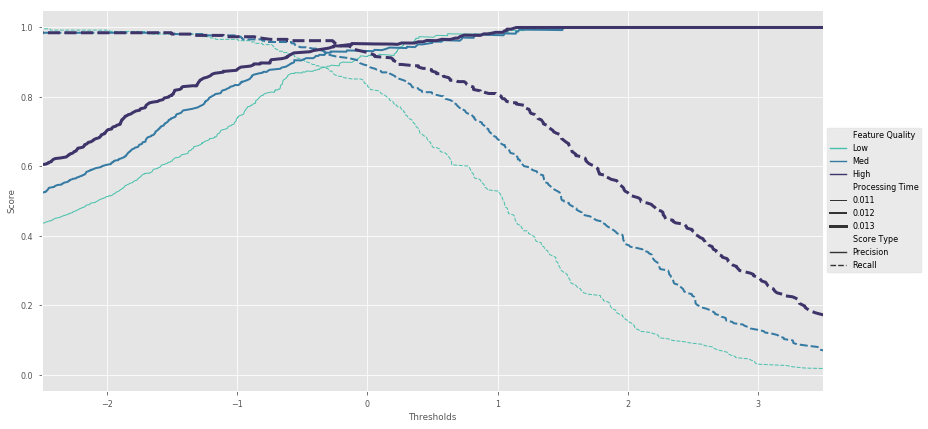

In [260]:
df_plot = df_data_3[df_data_3['Model'].isin(['LOG_REG'])] 
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Thresholds", y="Score", hue="Feature Quality", style="Score Type",size="Processing Time", 
                  sizes=(1, 3), palette=palette, legend="full", data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlim(-2.5,3.5)
plt.show()

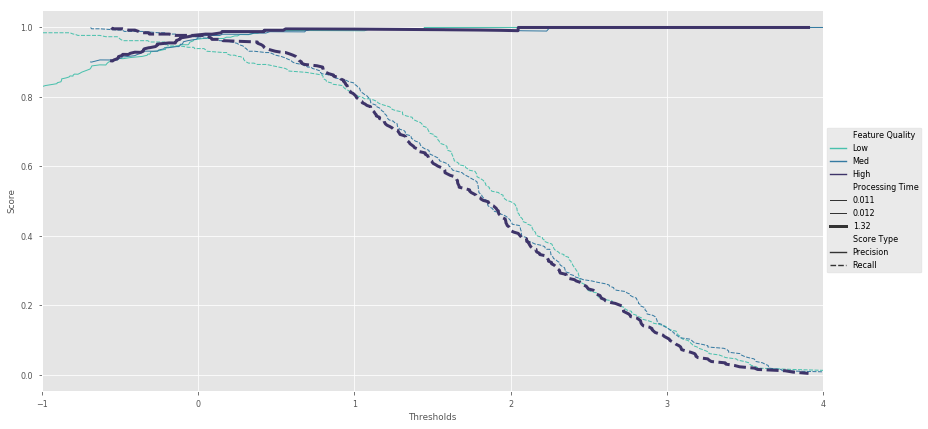

In [263]:
df_plot = df_data_3[df_data_3['Model'].isin(['SVC'])]
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Thresholds", y="Score", hue="Feature Quality", style="Score Type", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1, 3), data=df_plot)
ax.set_xlim(-1,4)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

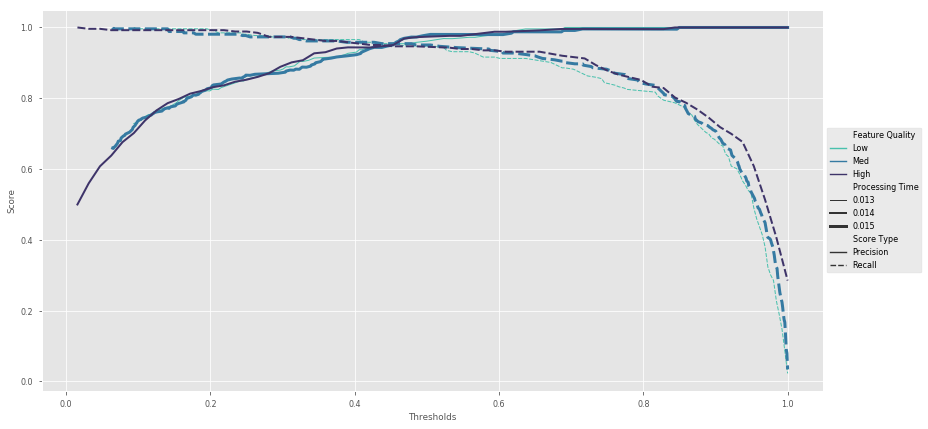

In [264]:
df_plot = df_data_3[df_data_3['Model'].isin(['RF'])] 
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Thresholds", y="Score", hue="Feature Quality", style="Score Type", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1, 3), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

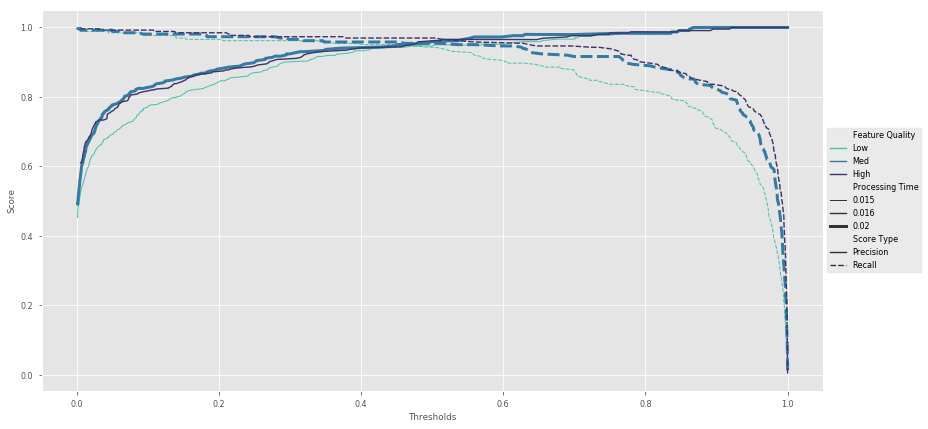

In [265]:
df_plot = df_data_3[df_data_3['Model'].isin(['MLP'])]
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Thresholds", y="Score", hue="Feature Quality", style="Score Type", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1, 3), data= df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# PR Curve

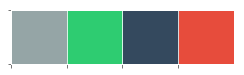

In [243]:
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = [ "#95a5a6", "#2ecc71", "#34495e", "#e74c3c"]
sns.palplot(sns.color_palette(flatui))

In [244]:
palette = sns.color_palette(flatui)

In [234]:
df_data_2.tail()

,Thresholds,Precisions,Recalls,Feature Quality,False Positives Rate,True Positive Rate,Processing Time,ROC AUC,Model
5076,0.999973,1.0,0.019011,High,NaN,NaN,0.030174,0.99528,MLP
5077,0.999997,1.0,0.015209,High,NaN,NaN,0.030174,0.99528,MLP
5078,0.999998,1.0,0.011407,High,NaN,NaN,0.030174,0.99528,MLP
5079,1.000000,1.0,0.007605,High,NaN,NaN,0.030174,0.99528,MLP
5080,1.000000,1.0,0.003802,High,NaN,NaN,0.030174,0.99528,MLP


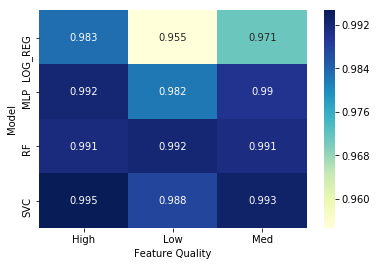

In [277]:
df_plot = df_data_2.pivot_table(index='Model', 
                        columns='Feature Quality', 
                        values='PR AUC')
ax = sns.heatmap(df_plot, annot=True, fmt='.3g', cmap="YlGnBu")

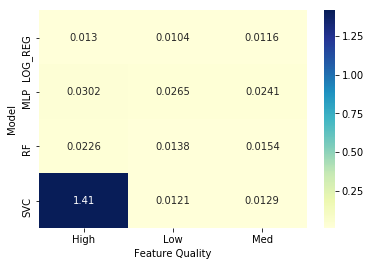

In [278]:
df_plot = df_data_2.pivot_table(index='Model', 
                        columns='Feature Quality', 
                        values='Processing Time')
ax = sns.heatmap(df_plot, annot=True, fmt='.3g', cmap="YlGnBu")

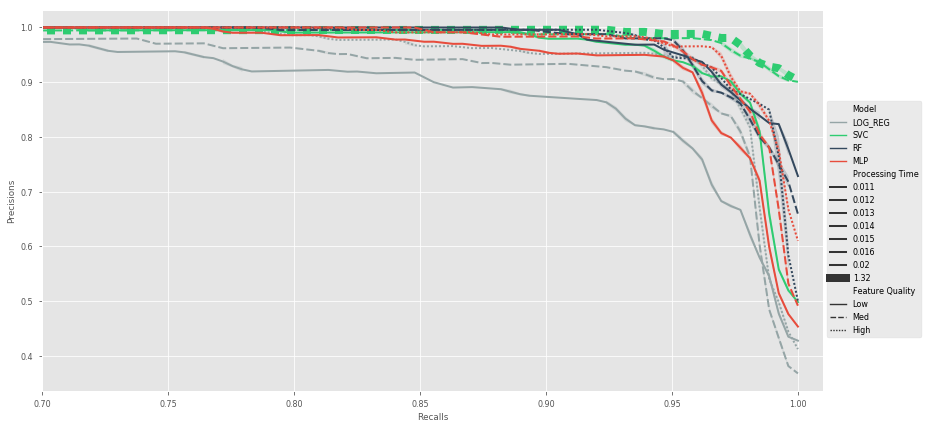

In [246]:
df_plot = df_data_2
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Model", style="Feature Quality",size="Processing Time", 
                  sizes=(2, 8), palette=palette, legend="full", data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.7,1.01)
plt.show()

In [266]:
palette = sns.color_palette("mako_r",3)

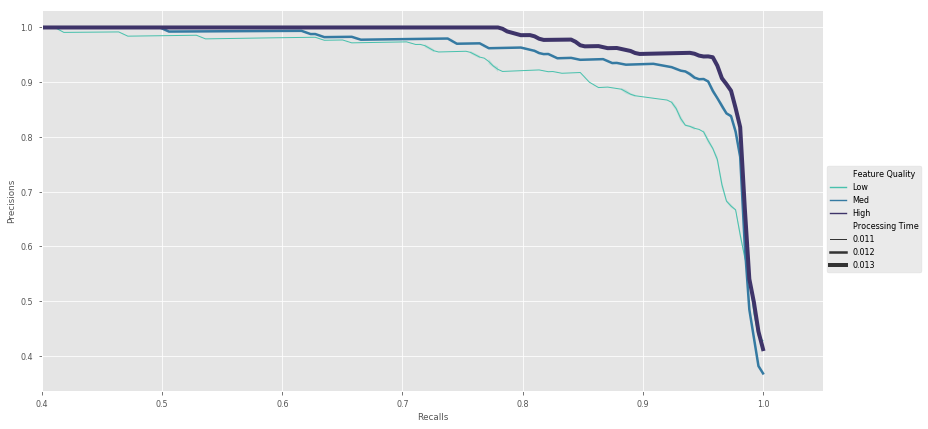

In [267]:
df_plot = df_data_2[df_data_2['Model']=='LOG_REG']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Feature Quality", size="Processing Time", sizes=(1, 4),
                  palette=palette, legend="full", data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.4,1.05)
plt.show()

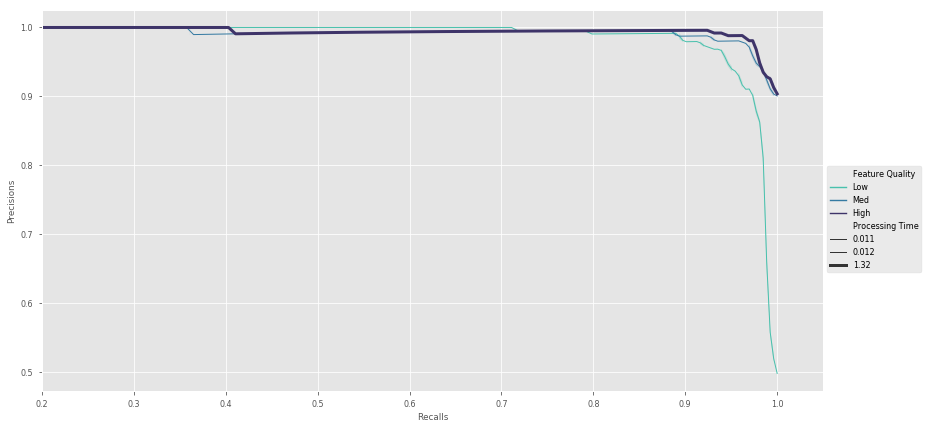

In [268]:
df_plot = df_data_2[df_data_2['Model']=='SVC']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Feature Quality", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1, 3), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.2,1.05)
plt.show()

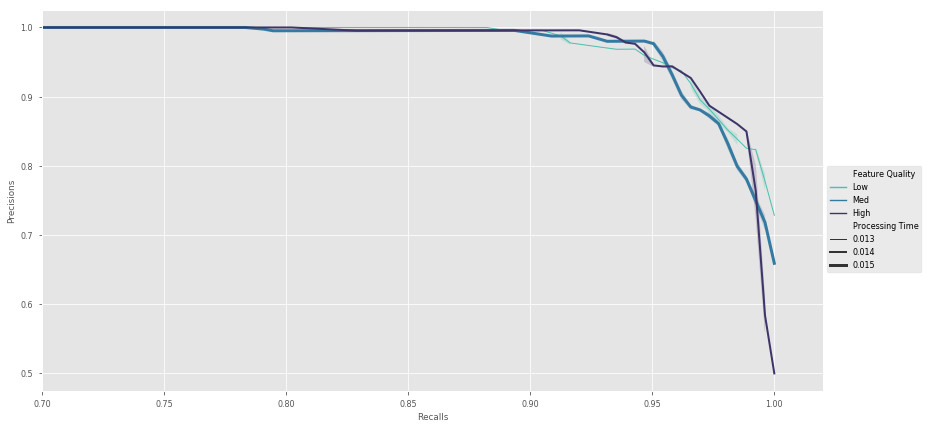

In [269]:
df_plot = df_data_2[df_data_2['Model']=='RF']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Model", palette=palette, 'Feature Quality'
                  size="Processing Time", legend="full", sizes=(1, 3), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.7,1.02)
plt.show()

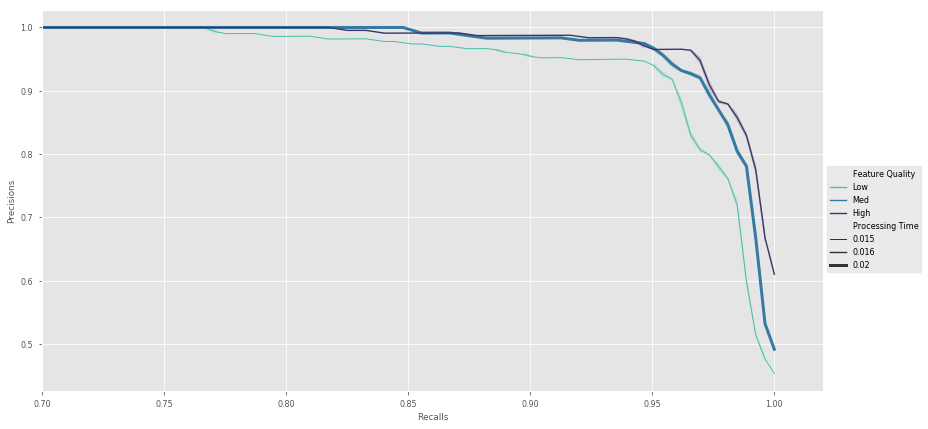

In [270]:
df_plot = df_data_2[df_data_2['Model']=='MLP']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Feature Quality", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1, 3), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.7,1.02)
plt.show()

# ROC Curve

In [312]:
palette = sns.color_palette(flatui)

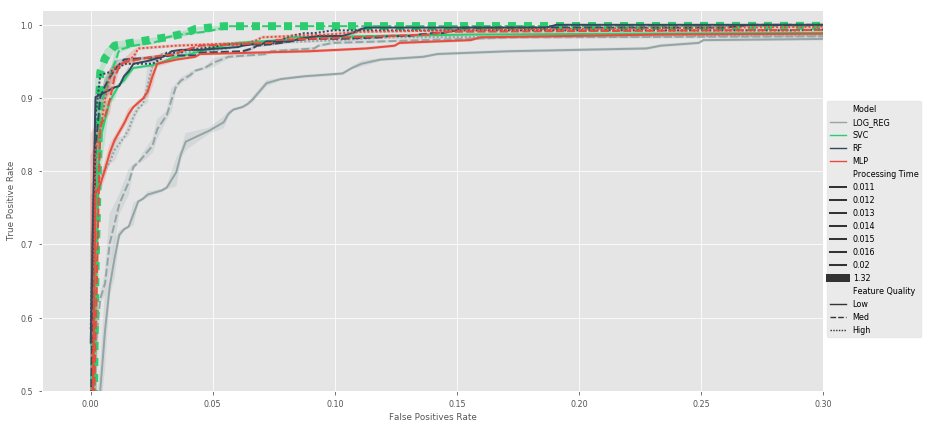

In [281]:
df_plot = df_data_2
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Model", palette=palette,
                 style="Feature Quality", size="Processing Time", legend="full", sizes=(2, 8), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(-0.02,0.3)
ax.set_ylim(0.5,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [293]:
palette = sns.color_palette("mako_r",3)

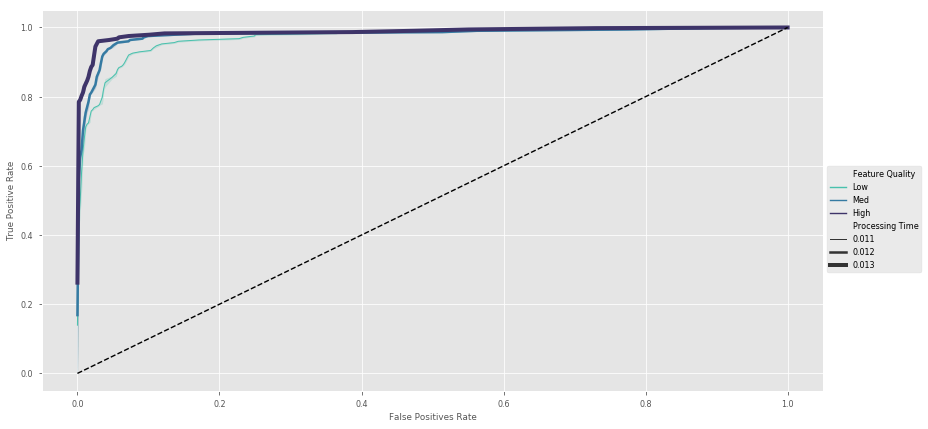

In [294]:
df_plot = df_data_2[df_data_2['Model']=='LOG_REG']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Feature Quality", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
#ax.set_xlim(0.7,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

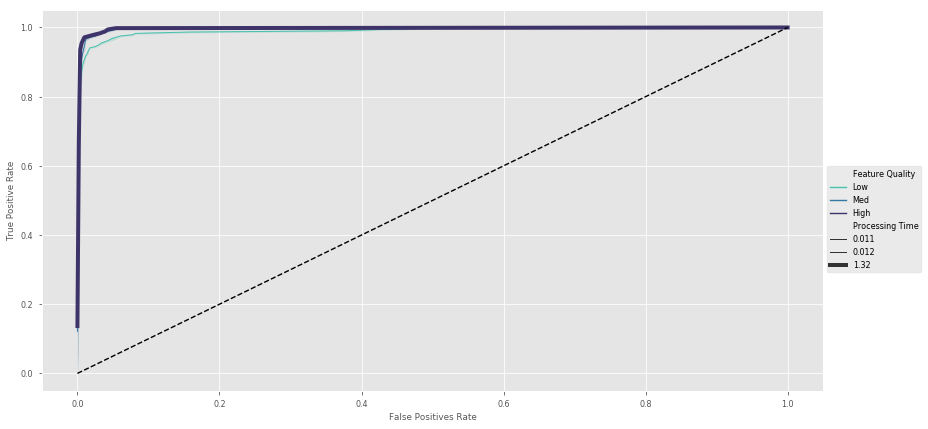

In [295]:
df_plot = df_data_2[df_data_2['Model']=='SVC']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Feature Quality", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
#ax.set_xlim(0.7,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

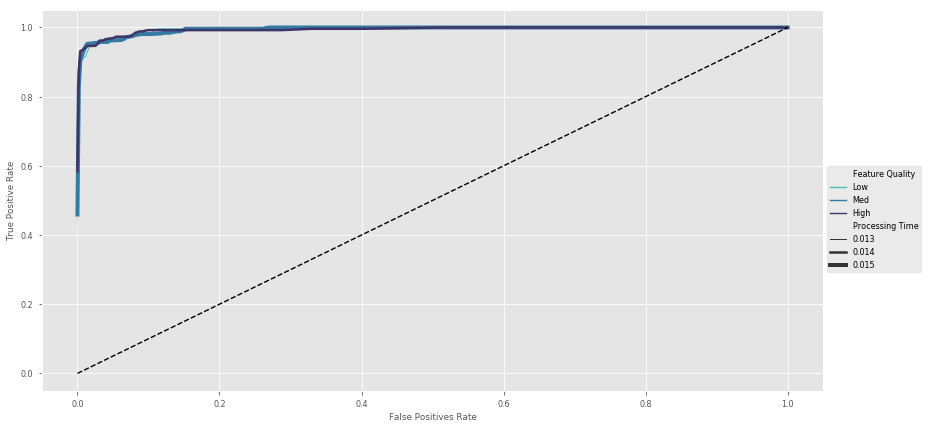

In [296]:
df_plot = df_data_2[df_data_2['Model']=='RF']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Feature Quality", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
#ax.set_xlim(0.7,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

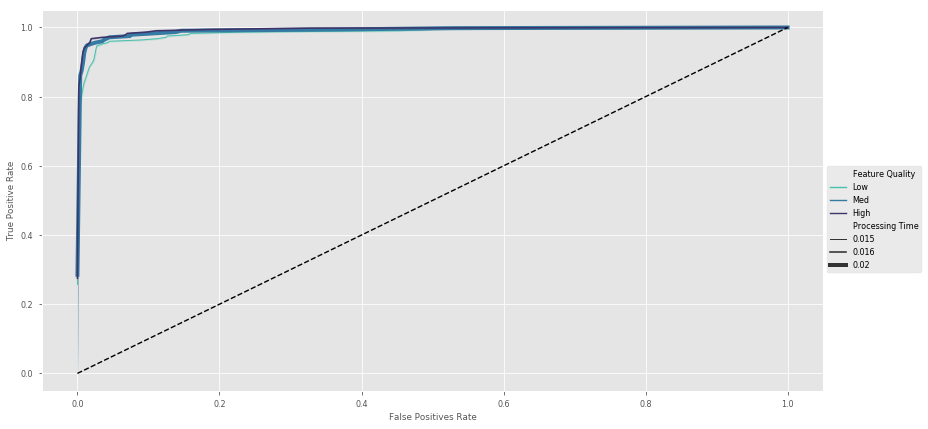

In [297]:
df_plot = df_data_2[df_data_2['Model']=='MLP']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Feature Quality", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
#ax.set_xlim(0.7,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

# Caracteristicas 

In [954]:
palette = sns.color_palette("mako_r",4)

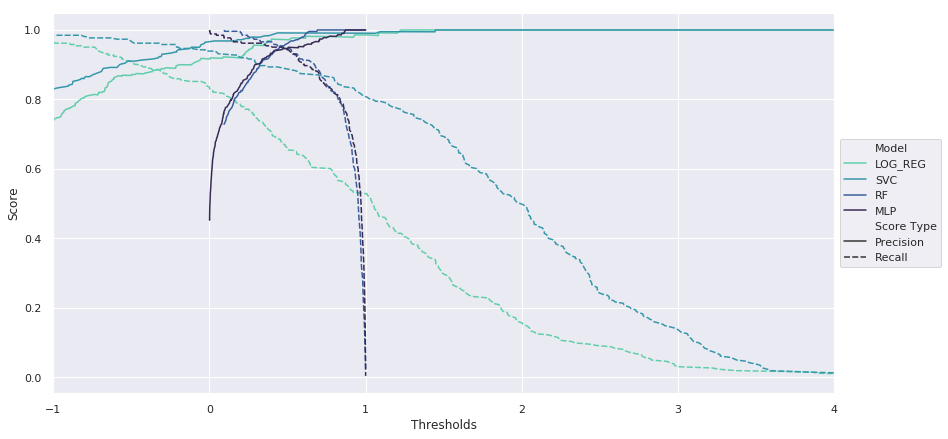

In [955]:
df_plot = df_data_3[df_data_3['Feature Quality']=='Low']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Thresholds", y="Score", hue="Model", style="Score Type", palette=palette, 
                  data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlim(-1,4)
plt.show()

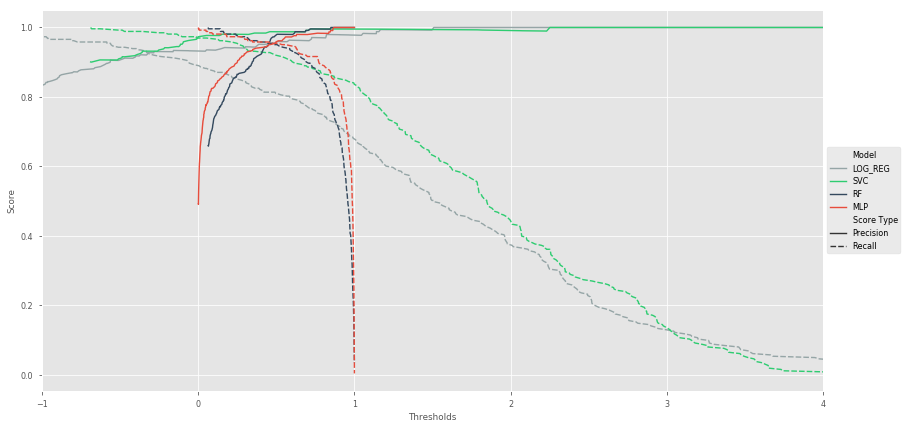

In [283]:
df_plot = df_data_3[df_data_3['Feature Quality']=='Med']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Thresholds", y="Score", hue="Model", style="Score Type", palette=palette, 
                  data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlim(-1,4)
plt.show()

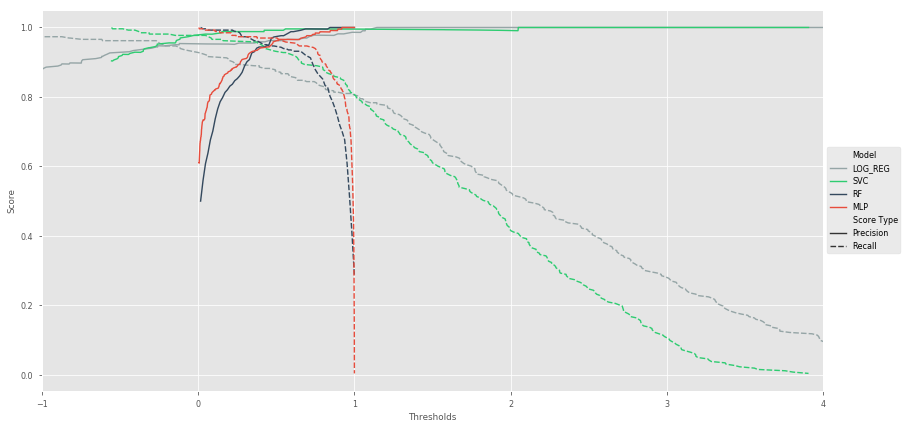

In [284]:
df_plot = df_data_3[df_data_3['Feature Quality']=='High']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Thresholds", y="Score", hue="Model", style="Score Type", palette=palette, 
                  data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlim(-1,4)
plt.show()

In [310]:
df_data_2.head()

,False Positives Rate,Feature Quality,Precisions,Processing Time,ROC AUC,Recalls,Thresholds,True Positive Rate,Model
0,0.000000,Low,0.427642,0.011,0.9799,1.000000,-2.560686,0.000000,LOG_REG
1,0.000000,Low,0.426710,0.011,0.9799,0.996198,-2.557044,0.003802,LOG_REG
2,0.000000,Low,0.427406,0.011,0.9799,0.996198,-2.554704,0.414449,LOG_REG
3,0.001946,Low,0.428105,0.011,0.9799,0.996198,-2.551426,0.414449,LOG_REG
4,0.001946,Low,0.428805,0.011,0.9799,0.996198,-2.549868,0.467681,LOG_REG


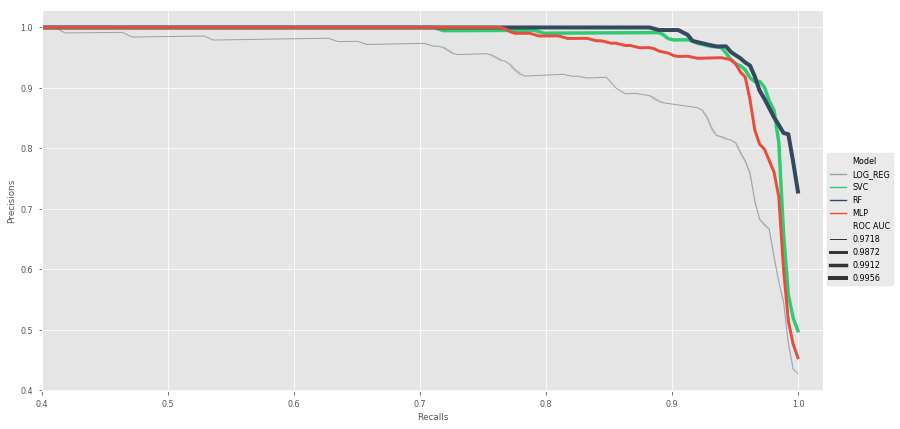

In [327]:
df_plot = df_data_2[df_data_2['Feature Quality']=='Low']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Model", palette=palette,
                  size="ROC AUC", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.4,1.02)
plt.show()

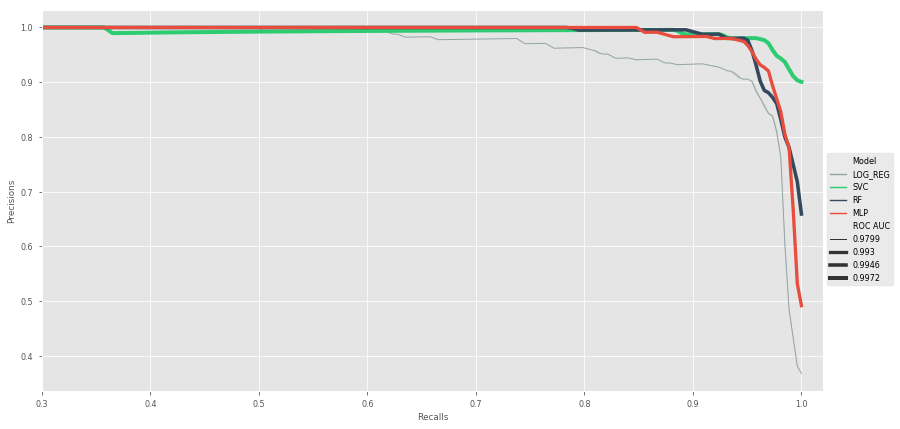

In [329]:
df_plot = df_data_2[df_data_2['Feature Quality']=='Med']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Model", palette=palette, 
                  size="ROC AUC", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.3,1.02)
plt.show()

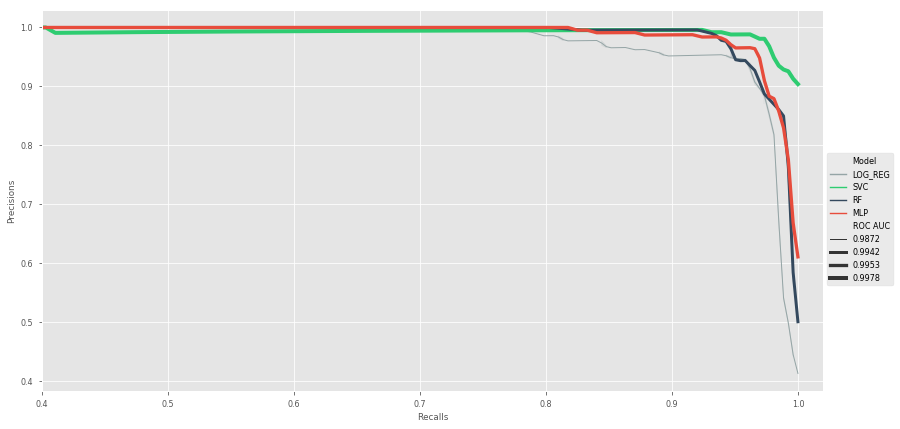

In [330]:
df_plot = df_data_2[df_data_2['Feature Quality']=='High']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="Recalls", y="Precisions", hue="Model", palette=palette, 
                  size="ROC AUC", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
ax.set_xlim(0.4,1.02)
plt.show()

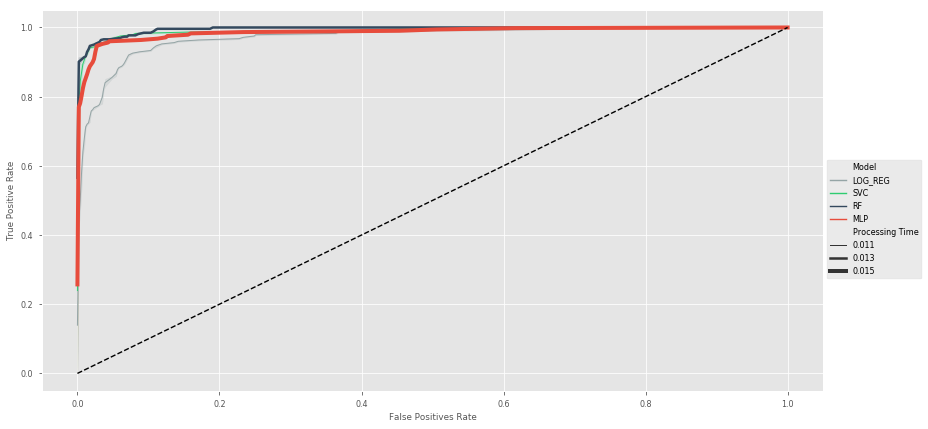

In [290]:
df_plot = df_data_2[df_data_2['Feature Quality']=='Low']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Model", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
#ax.set_xlim(0.7,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

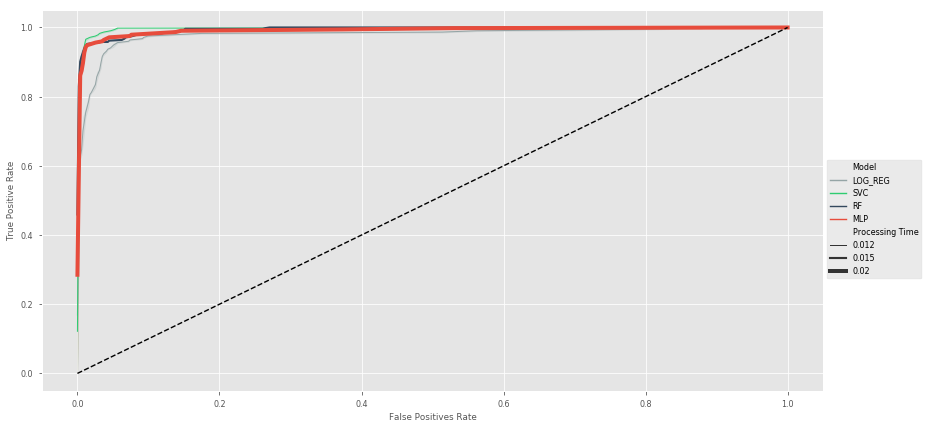

In [291]:
df_plot = df_data_2[df_data_2['Feature Quality']=='Med']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Model", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
#ax.set_xlim(0.7,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

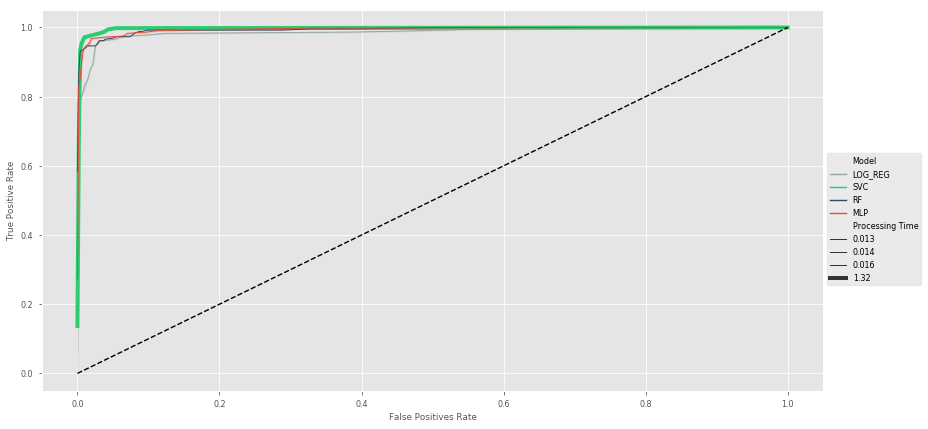

In [292]:
df_plot = df_data_2[df_data_2['Feature Quality']=='High']
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.lineplot(x="False Positives Rate", y="True Positive Rate", hue="Model", palette=palette, 
                  size="Processing Time", legend="full", sizes=(1,4), data=df_plot)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.45))
#ax.set_xlim(0.7,1.02)
plt.plot([0,1],[0,1], 'k--')
plt.show()

In [522]:
palette = sns.color_palette("mako_r",3)
#palette = sns.cubehelix_palette(3, start=0, rot=0, dark=0, light=0.6, reverse=False)
#palette = sns.hls_palette(3, l=.5)
#palette = sns.cubehelix_palette(3, start=0, rot=0, dark=0.2, light=.5)
#a4_dims = (14, 7)


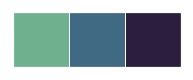

In [518]:
sns.palplot(sns.cubehelix_palette(3, start=.5, rot=-.75, light=0.6))

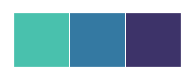

In [521]:
sns.palplot(sns.color_palette("mako_r",3))

In [590]:
palette = sns.cubehelix_palette(3, start=.5, rot=-.75, light=0.6)

# Standar Scale

Para finalizar se ve el efecto que tiene escalar los datos a: **media** cero y **desviación estándar** uno, **Standar Scale**, sobre los modelos anteriores. Para esto se van usar el conjunto de características de calidad media **med**:  

In [40]:
from sklearn.preprocessing import StandardScaler
X_med_s = StandardScaler().fit_transform(X_med)
X_train_med_s, X_test_med_s, y_train_med_s, y_test_med_s = split(X_med_s, y_med)

# Regrasion Logistica

In [41]:
log_reg(param_grid_log_reg, X_train_med_s, y_train_med_s, X_test_med_s, y_test_med_s)

Best Params: {'C': 0.5} 

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       221
           1       0.96      0.98      0.97       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.98      0.98      0.98       333
weighted avg       0.98      0.98      0.98       333



# Support Vector Machine - rbf (Kernel Gausiano)

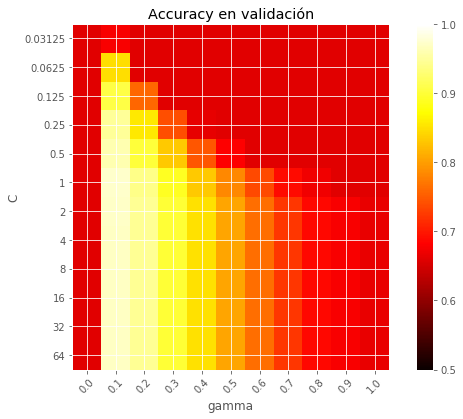

Best Params: {'C': 1, 'gamma': 0.1} 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       221
           1       0.99      0.89      0.94       112

   micro avg       0.96      0.96      0.96       333
   macro avg       0.97      0.94      0.96       333
weighted avg       0.96      0.96      0.96       333



In [42]:
SVM_rbf_clf(param_grid_svm_rbf, X_train_med_s, y_train_med_s, X_test_med_s, y_test_med_s)

# Random Forests

/home/juanfe/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


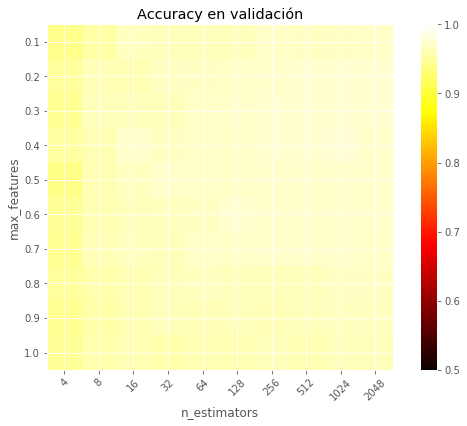

Best Params: {'max_features': 0.4, 'n_estimators': 1024} 

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       221
           1       1.00      0.96      0.98       112

   micro avg       0.98      0.98      0.98       333
   macro avg       0.99      0.98      0.98       333
weighted avg       0.99      0.98      0.98       333



In [43]:
random_forests_clf(param_grid_rf, X_train_med_s, y_train_med_s, X_test_med_s, y_test_med_s)

# Red Neuronal

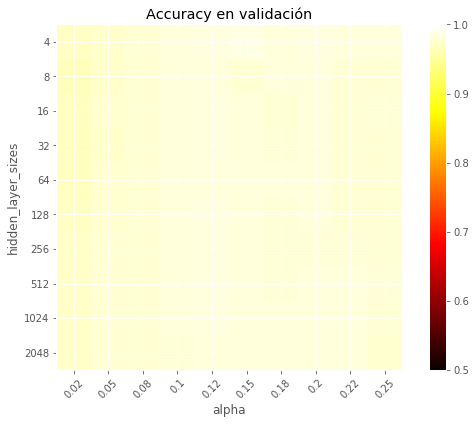

Best Params: {'alpha': 0.02, 'hidden_layer_sizes': 128} 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       221
           1       1.00      0.97      0.99       112

   micro avg       0.99      0.99      0.99       333
   macro avg       0.99      0.99      0.99       333
weighted avg       0.99      0.99      0.99       333



In [44]:
mlp_clf(param_grid_mlp, X_train_med_s, y_train_med_s, X_test_med_s, y_test_med_s)